## Packages

In [40]:
import pandas as pd
import numpy as np
import os
import glob
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import manifold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import statsmodels.api as sm
from matplotlib import offsetbox
from time import time

#os.chdir('C:\\Users\\A Sua\\Documents\\FIU\\CAP2020')
os.chdir('C:\\Users\\Daniel\\Python and R Notebooks\\CAP2020\\CAP2020')

## Define Functions

In [41]:
folder = "C:\\Users\\Daniel\\Python and R Notebooks\\CAP2020\\CAP2020\\data\\processed"
final_data = "data\\processed\\compiled_quarterly_final_v2.csv"

In [42]:
#print computation time script
def timing(f):
    def wrap(*args):
        time1 = time()
        ret = f(*args)
        time2 = time()
        print('{:s} function took {:.3f} ms'.format(f.__name__, (time2-time1)*1000.0))

        return ret
    return wrap

In [43]:
def duplicated_varnames(df):
    """Return a dict of all variable names that 
    are duplicated in a given dataframe."""
    repeat_dict = {}
    var_list = list(df) # list of varnames as strings
    for varname in var_list:
        # make a list of all instances of that varname
        test_list = [v for v in var_list if v == varname] 
        # if more than one instance, report duplications in repeat_dict
        if len(test_list) > 1: 
            repeat_dict[varname] = len(test_list)
    return repeat_dict

In [44]:
def plot_embedding(X, y, title=None, xlabel=None, ylabel=None):
    x_min, x_max = np.min(X, 0)-5, np.max(X, 0)+5
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)
    plt.show()
        
def new_embedding(X, title=None, xlabel=None, ylabel=None):
    plt.scatter(X[:,0], X[:,1])
    
    if title is not None:
        plt.title(title)
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)
    plt.show()
    
def colorize_kmeans(data, num_clusters, step_size, num_iter=10, title=None, xlabel=None, ylabel=None):
    reduced_data = data
    kmeans = KMeans(init='k-means++', n_clusters=num_clusters, n_init=num_iter) ## 3 clusters run with 
    kmeans.fit(reduced_data)
    
    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = step_size    # point in the mesh [x_min, x_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = reduced_data[:, 0].min() - 5., reduced_data[:, 0].max() + 5.
    y_min, y_max = reduced_data[:, 1].min() - 5., reduced_data[:, 1].max() + 5.
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Obtain labels for each point in mesh. Use last trained model.
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1)
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')

    plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
    # Plot the centroids as a white X
    centroids = kmeans.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker = 'x',
                #marker=[str(centroids[i]) for i in range(len(centroids))], 
                s=75, linewidths=3,
                color='w', zorder=10)
    ## plot cluster numbers
    centroid_num_list = [str(i) for i in range(num_clusters)]
    for value, marker in enumerate(centroid_num_list):
        plt.text(kmeans.cluster_centers_[value, 0]+.03, kmeans.cluster_centers_[value, 1]+.01, s = marker, 
                 fontdict= {'family' : 'normal', 'weight' : 'bold','size': 22}, c='w')
    
    #plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
              #'Centroids are marked with white cross')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    #plt.xticks(())
    #plt.yticks(())
    plt.show()
    return kmeans     

## Import Data

In [45]:
df2 = pd.read_csv(final_data)
print('initial shape {}'.format(df2.shape))
df2.head()

initial shape (62252, 11)


Quarter end  Shares split adjusted  Price  EPS basic  EPS diluted  \
0   9/30/2019               67151778  63.99       0.59         0.58   
1   6/30/2019               67547497  57.23       0.63         0.62   
2   3/31/2019               67677449  48.63       0.83         0.82   
3  12/31/2018               67202919  47.00       0.90         0.89   
4   9/30/2018               68594784  48.86       0.64         0.62   

   Dividend per share  Dividend payout ratio  P/E ratio  \
0               0.035                 0.0488      21.69   
1               0.035                 0.0464      19.94   
2               0.035                 0.0459      17.49   
3               0.040                 0.0455      10.83   
4               0.030                 0.0267      12.00   

   Long-term debt to equity ratio Symbol Quarter  
0                          0.1859    AAN  2019Q3  
1                          0.1880    AAN  2019Q2  
2                          0.2251    AAN  2019Q1  
3                          0.1937    AAN  2018Q4  
4                          0.1686    AAN  2018Q3

In [46]:
# build price dataframe for portfolio choosing and comparison
price = df2[['Quarter', 'Symbol', 'Price']]
price = price.iloc[::-1]
price.head()

Quarter Symbol  Price
62251  2013Q1    ZTS  32.95
62250  2013Q2    ZTS  32.07
62249  2013Q3    ZTS  30.78
62248  2013Q4    ZTS  32.10
62247  2014Q1    ZTS  30.75

In [47]:
stock_list = price.Symbol.unique()
columns = list(price.Quarter.unique())
columns.sort()
price_final = pd.DataFrame(columns = columns)

In [48]:
# Look for duplicate quarters to fix

for stock in stock_list:
    df = price[price['Symbol']==stock]
    df = df[['Quarter', 'Price']]
    df.set_index('Quarter', inplace = True)
    
    df = df.T
    
    as_list = df.index.tolist()
    idx = as_list.index('Price')
    as_list[idx] = stock
    df.index = as_list
    
    print(stock, duplicated_varnames(df))

ZTS {}
ZMH {}
ZION {}
YUM {}
YHOO {}
X {}
XYL {}
XTO {}
XRX {}
XRAY {}
XOM {}
XL {}
XLNX {}
XEL {}
XEC {}
WY {}
WYN {}
WYNN {}
WYE {}
WWY {}
WU {}
WRK {}
WPX {}
WPO {}
WPI {}
WM {}
WM_old {}
WMT {}
WMB {}
WLTW {}
WLP {}
WIN {}
WINA {}
WHR {}
WFT {}
WFR {}
WFMI {}
WFC {}
WEN {}
WEC {}
WDR {}
WDC {}
WB {}
WBA {}
WAT {}
WAG {}
V {}
VZ {}
VTR {}
VRTX {}
VRSN {}
VRSK {}
VNO {}
VMC {}
VLO {}
VIVO {}
VIA.B {}
VFC {}
VAR {}
UTX {}
UST {}
USB {}
URI {}
URBN {}
UPS {}
UNP {}
UNM {}
UNH {}
ULTA {}
UIS {}
UHS {}
UG {}
UDR {}
UA {}
UAL {}
T {}
TYC {}
TXT {}
TXN {}
TWX {}
TWTR {}
TWC {}
TT {}
TSS {}
TSO {}
TSN {}
TSLA {}
TSCO {}
TRV {}
TROW {}
TRIP {}
TMO {}
TMK {}
TLAB {}
TKR {}
TJX {}
TIN {}
TIF {}
TIE {}
THC {}
TGT {}
TE {}
TEX {}
TER {}
TEL {}
TEG {}
TDG {}
TDC {}
TAP {}
S {}
SYY {}
SYNT {}
SYMC {}
SYK {}
SYF {}
SWY {}
SWN {}
SWK {}
SWKS {}
SVU {}
SUN {}
STZ {}
STX {}
STT {}
STR {}
STJ {}
STI {}
SSP {}
SRE {}
SRCL {}
SPLS {}
SPG {}
SO {}
SOV {}
SNPS {}
SNI {}
SNDK {}
SNA {}
SLM {}
SLG {}
SLE {}


In [49]:
# dataframe builder
for stock in stock_list:
    df = price[price['Symbol']==stock]
    df = df[['Quarter', 'Price']]
    df.set_index('Quarter', inplace = True)
    
    df = df.T
    
    as_list = df.index.tolist()
    idx = as_list.index('Price')
    as_list[idx] = stock
    df.index = as_list
    
    price_final = pd.concat([price_final, df], sort = True)

In [50]:
price_final

1993Q2  1993Q3  1993Q4  1994Q1  1994Q2  1994Q3  1994Q4  1995Q1  1995Q2  \
ZTS      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
ZMH      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
ZION     NaN     NaN   10.19    9.54    9.88    9.89    9.10    9.51   11.02   
YUM      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
YHOO     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
ABBV     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
AA       NaN     NaN     NaN     NaN     NaN     NaN     NaN   30.61   34.17   
AAP      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
AAPL     NaN     NaN    1.20     NaN    1.04    1.12    1.36    1.46    1.50   
AAN      NaN     NaN     NaN     NaN     NaN     NaN    1.79    1.94    2.18   

      1995Q3  ...  2017Q3  2017Q4  2018Q1  2018Q2  2018Q3  2018Q4  2019Q1  \
ZTS      NaN  ...   62.66   68.31   77.97   83.13   88.46   87.73   91.16   
ZMH      NaN  ...  121.79  116.46  118.33  111.25  122.27  114.65  114.08   
ZION   13.88  ...   44.47   47.85   53.52   55.02   52.39   45.17   45.92   
YUM      NaN  ...   75.26   78.83   81.41   82.75   84.18   89.33   94.95   
YHOO     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
...      ...  ...     ...     ...     ...     ...     ...     ...     ...   
ABBV     NaN  ...   80.16   92.17  108.49   97.73   93.50   87.05   84.03   
AA     41.30  ...   24.76   25.30   26.87   20.27   19.88   19.62   18.37   
AAP      NaN  ...   98.81   93.30  111.81  122.78  155.00  167.26  166.31   
AAPL    1.51  ...  153.68  164.83  166.87  177.41  206.54  190.03  169.84   
AAN     2.55  ...   42.68   39.67   42.98   43.87   48.86   47.00   48.63   

      2019Q2  2019Q3  2019Q4  
ZTS      NaN     NaN     NaN  
ZMH      NaN     NaN     NaN  
ZION     NaN     NaN     NaN  
YUM      NaN     NaN     NaN  
YHOO     NaN     NaN     NaN  
...      ...     ...     ...  
ABBV     NaN     NaN     NaN  
AA     22.55     NaN     NaN  
AAP      NaN     NaN     NaN  
AAPL  192.79  209.50     NaN  
AAN    57.23   63.99     NaN  

[762 rows x 107 columns]

### D/E ratio - make dataframe

In [51]:
de_ratio = df2[['Quarter', 'Symbol', 'Long-term debt to equity ratio']]
de_ratio = de_ratio.iloc[::-1]
de_final = pd.DataFrame(columns = columns)

In [52]:
# dataframe builder
for stock in stock_list:
    df = de_ratio[de_ratio['Symbol']==stock]
    df = df[['Quarter', 'Long-term debt to equity ratio']]
    df.set_index('Quarter', inplace = True)
    
    df = df.T
    
    as_list = df.index.tolist()
    idx = as_list.index('Long-term debt to equity ratio')
    as_list[idx] = stock
    df.index = as_list
    
    de_final = pd.concat([de_final, df], sort = True)

In [53]:
# drop WYNN due to huge outlier in TSNE analysis
de_final = de_final.drop(index =['WYNN'])
de_final

1993Q2  1993Q3  1993Q4  1994Q1  1994Q2  1994Q3  1994Q4  1995Q1  1995Q2  \
ZTS      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
ZMH      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
ZION     NaN     NaN   0.000   0.000  0.0000  0.0000  0.0000  0.0000  0.0000   
YUM      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
YHOO     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
ABBV     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
AA       NaN     NaN   0.406   0.458  0.3581  0.3057  0.2611  0.2593  0.2479   
AAP      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
AAPL     NaN     NaN   0.000     NaN  0.1358  0.1278  0.1187  0.1120  0.1071   
AAN      NaN     NaN     NaN     NaN     NaN     NaN  0.0000  0.0000  0.0000   

      1995Q3  ...  2017Q3  2017Q4  2018Q1  2018Q2  2018Q3  2018Q4  2019Q1  \
ZTS      NaN  ...  2.4897  2.7983  2.5276  2.5152  3.0411  2.9487  2.8390   
ZMH      NaN  ...  0.8804  0.7599  0.7907  0.7816  0.7037  0.7465  0.7205   
ZION  0.0000  ...  0.0534  0.0540  0.0543  0.0544  0.1258  0.1033  0.1749   
YUM      NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
YHOO     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
...      ...  ...     ...     ...     ...     ...     ...     ...     ...   
ABBV     NaN  ...  5.0806  6.0728  8.6986     NaN     NaN     NaN     NaN   
AA    0.3304  ...  1.1543  1.4019  1.2102  1.2259  1.1902  1.0685  1.1542   
AAP      NaN  ...  0.3231  0.3058  0.2946  0.2857  0.2857  0.2945  0.2105   
AAPL  0.1044  ...  0.7252  0.7412  0.7989  0.8450  0.8748  0.7888  0.8521   
AAN   0.0000  ...  0.1741  0.1572  0.2041  0.1564  0.1686  0.1937  0.2251   

      2019Q2  2019Q3  2019Q4  
ZTS      NaN     NaN     NaN  
ZMH      NaN     NaN     NaN  
ZION     NaN     NaN     NaN  
YUM      NaN     NaN     NaN  
YHOO     NaN     NaN     NaN  
...      ...     ...     ...  
ABBV     NaN     NaN     NaN  
AA    1.2296     NaN     NaN  
AAP      NaN     NaN     NaN  
AAPL  0.8806  1.0146     NaN  
AAN   0.1880  0.1859     NaN  

[761 rows x 107 columns]

In [54]:
# drop rows with all NAN's
de_final.dropna(how = 'all', inplace=True)
de_final

1993Q2  1993Q3  1993Q4  1994Q1  1994Q2  1994Q3  1994Q4  1995Q1  1995Q2  \
ZTS      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
ZMH      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
ZION     NaN     NaN   0.000   0.000  0.0000  0.0000  0.0000  0.0000  0.0000   
YUM      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
YHOO     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
ABBV     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
AA       NaN     NaN   0.406   0.458  0.3581  0.3057  0.2611  0.2593  0.2479   
AAP      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
AAPL     NaN     NaN   0.000     NaN  0.1358  0.1278  0.1187  0.1120  0.1071   
AAN      NaN     NaN     NaN     NaN     NaN     NaN  0.0000  0.0000  0.0000   

      1995Q3  ...  2017Q3  2017Q4  2018Q1  2018Q2  2018Q3  2018Q4  2019Q1  \
ZTS      NaN  ...  2.4897  2.7983  2.5276  2.5152  3.0411  2.9487  2.8390   
ZMH      NaN  ...  0.8804  0.7599  0.7907  0.7816  0.7037  0.7465  0.7205   
ZION  0.0000  ...  0.0534  0.0540  0.0543  0.0544  0.1258  0.1033  0.1749   
YUM      NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
YHOO     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
...      ...  ...     ...     ...     ...     ...     ...     ...     ...   
ABBV     NaN  ...  5.0806  6.0728  8.6986     NaN     NaN     NaN     NaN   
AA    0.3304  ...  1.1543  1.4019  1.2102  1.2259  1.1902  1.0685  1.1542   
AAP      NaN  ...  0.3231  0.3058  0.2946  0.2857  0.2857  0.2945  0.2105   
AAPL  0.1044  ...  0.7252  0.7412  0.7989  0.8450  0.8748  0.7888  0.8521   
AAN   0.0000  ...  0.1741  0.1572  0.2041  0.1564  0.1686  0.1937  0.2251   

      2019Q2  2019Q3  2019Q4  
ZTS      NaN     NaN     NaN  
ZMH      NaN     NaN     NaN  
ZION     NaN     NaN     NaN  
YUM      NaN     NaN     NaN  
YHOO     NaN     NaN     NaN  
...      ...     ...     ...  
ABBV     NaN     NaN     NaN  
AA    1.2296     NaN     NaN  
AAP      NaN     NaN     NaN  
AAPL  0.8806  1.0146     NaN  
AAN   0.1880  0.1859     NaN  

[760 rows x 107 columns]

In [55]:
#fill NANs with row average
m = de_final.mean(axis = 1)
for i, col in enumerate(de_final):
    de_final.iloc[:, i] = de_final.iloc[:, i].fillna(m)
de_final.shape

(760, 107)

In [56]:
# drop all rows with only 0's
de_final = de_final[(de_final.T !=0).any()]
de_final.shape

(731, 107)

In [57]:
# drop the same stocks from the price dataframe
idx1 = price_final.index
idx2 = de_final.index
idx_diff=idx1.difference(idx2)
idx_diff

Index(['ACAS', 'BKE', 'BSC', 'CB', 'CFC', 'CRA', 'CRVL', 'EXPD', 'FFIV', 'FNM',
       'FRX', 'HCA', 'HCBK', 'JPM', 'LEH', 'MER', 'MI', 'NCC', 'NILE', 'PETS',
       'PFIE', 'PLD_old', 'SAF', 'SAPE', 'SOV', 'TROW', 'TRV', 'UG', 'WB',
       'WM_old', 'WYNN'],
      dtype='object')

In [58]:
price_final.drop(idx_diff, inplace=True)
price_final

1993Q2  1993Q3  1993Q4  1994Q1  1994Q2  1994Q3  1994Q4  1995Q1  1995Q2  \
ZTS      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
ZMH      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
ZION     NaN     NaN   10.19    9.54    9.88    9.89    9.10    9.51   11.02   
YUM      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
YHOO     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
ABBV     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
AA       NaN     NaN     NaN     NaN     NaN     NaN     NaN   30.61   34.17   
AAP      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
AAPL     NaN     NaN    1.20     NaN    1.04    1.12    1.36    1.46    1.50   
AAN      NaN     NaN     NaN     NaN     NaN     NaN    1.79    1.94    2.18   

      1995Q3  ...  2017Q3  2017Q4  2018Q1  2018Q2  2018Q3  2018Q4  2019Q1  \
ZTS      NaN  ...   62.66   68.31   77.97   83.13   88.46   87.73   91.16   
ZMH      NaN  ...  121.79  116.46  118.33  111.25  122.27  114.65  114.08   
ZION   13.88  ...   44.47   47.85   53.52   55.02   52.39   45.17   45.92   
YUM      NaN  ...   75.26   78.83   81.41   82.75   84.18   89.33   94.95   
YHOO     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
...      ...  ...     ...     ...     ...     ...     ...     ...     ...   
ABBV     NaN  ...   80.16   92.17  108.49   97.73   93.50   87.05   84.03   
AA     41.30  ...   24.76   25.30   26.87   20.27   19.88   19.62   18.37   
AAP      NaN  ...   98.81   93.30  111.81  122.78  155.00  167.26  166.31   
AAPL    1.51  ...  153.68  164.83  166.87  177.41  206.54  190.03  169.84   
AAN     2.55  ...   42.68   39.67   42.98   43.87   48.86   47.00   48.63   

      2019Q2  2019Q3  2019Q4  
ZTS      NaN     NaN     NaN  
ZMH      NaN     NaN     NaN  
ZION     NaN     NaN     NaN  
YUM      NaN     NaN     NaN  
YHOO     NaN     NaN     NaN  
...      ...     ...     ...  
ABBV     NaN     NaN     NaN  
AA     22.55     NaN     NaN  
AAP      NaN     NaN     NaN  
AAPL  192.79  209.50     NaN  
AAN    57.23   63.99     NaN  

[731 rows x 107 columns]

## Exploring PCA and t-SNE

### PCA-100

In [59]:
pca100 = PCA(n_components=100)
pca100.fit(de_final)
print('Percentage of Explained Variance')
print(sum(pca100.explained_variance_ratio_))

Percentage of Explained Variance
0.9999964159543637


### PCA-50

In [60]:
pca50 = PCA(n_components=50)
pca50.fit(de_final)
print('Percentage of Explained Variance')
print(sum(pca50.explained_variance_ratio_))

Percentage of Explained Variance
0.9973399327622837


### PCA-25

In [61]:
pca25 = PCA(n_components=25)
pca25.fit(de_final)
print('Percentage of Explained Variance')
print(sum(pca25.explained_variance_ratio_))

Percentage of Explained Variance
0.9684215239467575


### PCA-10

In [62]:
pca10 = PCA(n_components=10)
pca10.fit(de_final)
print('Percentage of Explained Variance')
print(sum(pca10.explained_variance_ratio_))

Percentage of Explained Variance
0.8008258235455109


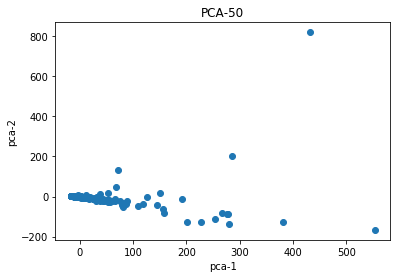

In [63]:
# we'll pick pca-50 for our analysis
de_pca = pca50.fit_transform(de_final)
new_embedding(de_pca, title='PCA-50', xlabel='pca-1', ylabel='pca-2')

### t-SNE pseudo-Grid search

In [64]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0, perplexity=15, learning_rate=1000)
X_test_tsne = tsne.fit_transform(de_pca)
X_tsne_df = pd.DataFrame(data = X_test_tsne, index = de_final.index)

In [65]:
X_tsne_df.sort_values(by=[0])

0          1
OFLX  -77.614647  17.804996
GLAD  -77.328316  23.287970
GRMN  -77.049507  20.056517
ETFC  -76.999321  23.395496
ALGN  -76.043152  18.763527
...          ...        ...
NAVI  133.200378 -61.745304
CVC   133.274109 -61.366299
EQ    134.465805 -60.123161
AMCX  134.487320 -62.109699
THC   135.007614 -62.431854

[731 rows x 2 columns]

In [66]:
X_tsne_df.sort_values(by=[1])

0          1
WU    131.861542 -63.090187
THC   135.007614 -62.431854
AMCX  134.487320 -62.109699
NAVI  133.200378 -61.745304
CVC   133.274109 -61.366299
...          ...        ...
A     -25.291393  35.106808
ILMN  -34.177189  35.881451
ODP   -26.770710  35.934044
DELL  -28.435776  36.070137
ADCT  -24.389837  36.151798

[731 rows x 2 columns]

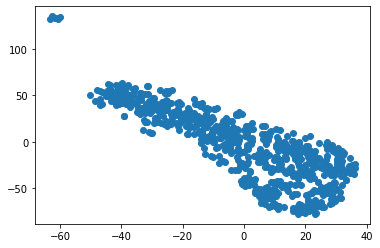

In [67]:
plt.scatter(X_test_tsne[:,1], X_test_tsne[:,0])

In [68]:
k_value = 30
step = 0.5
dic_of_top_stocks = {}

Learning Rate=100


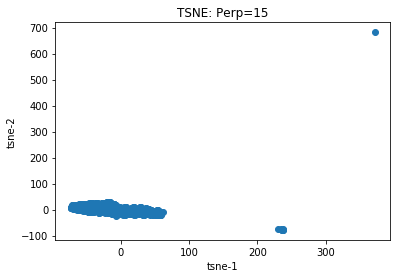

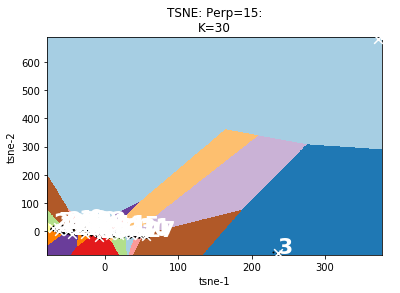

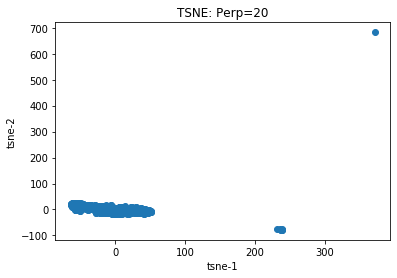

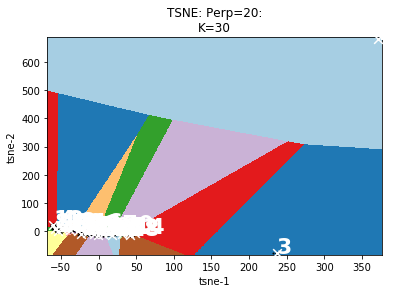

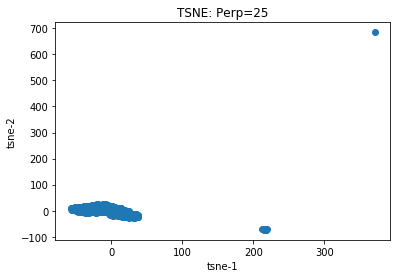

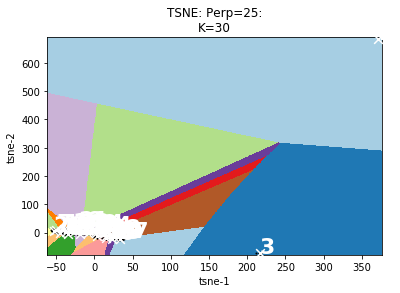

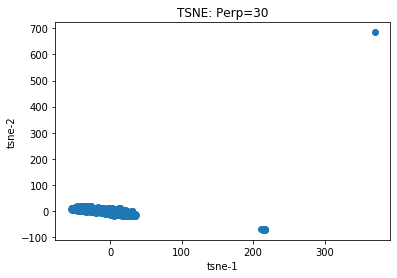

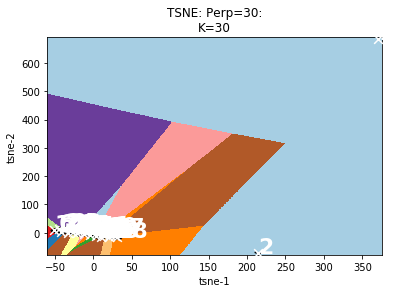

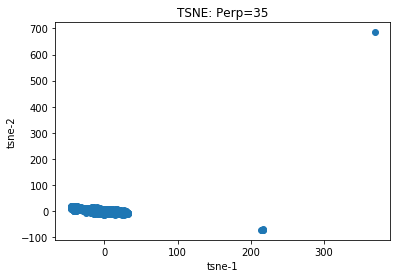

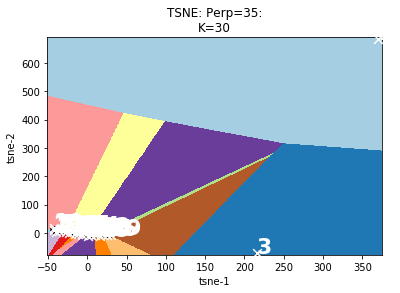

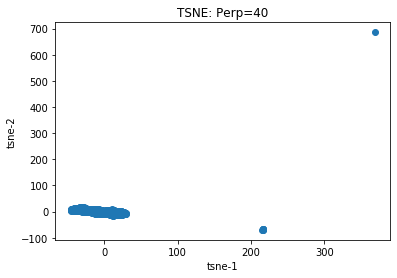

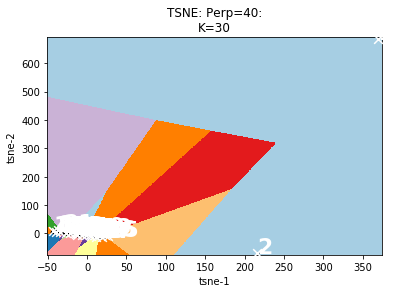

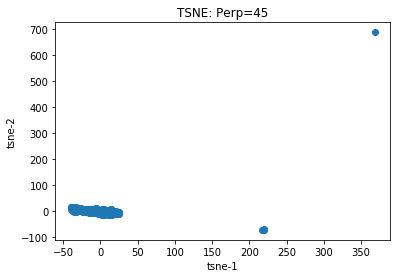

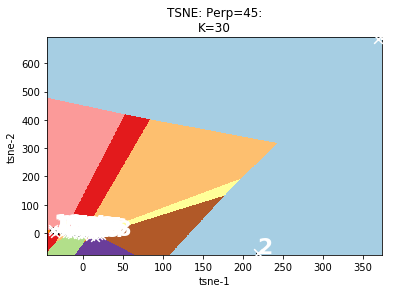

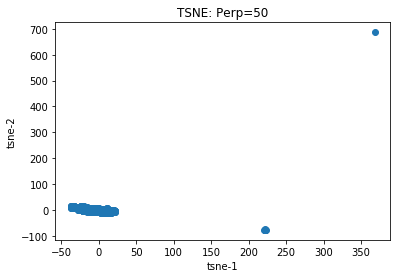

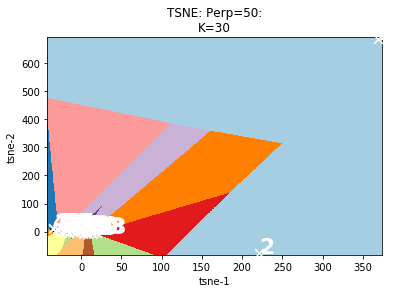

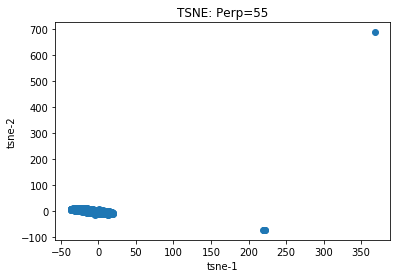

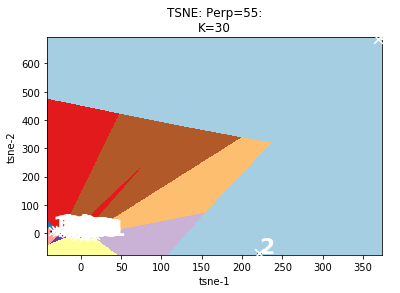

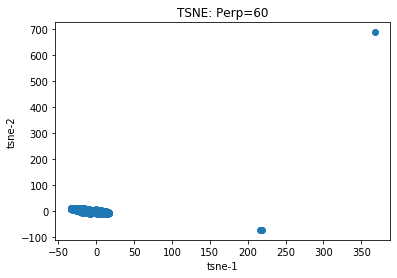

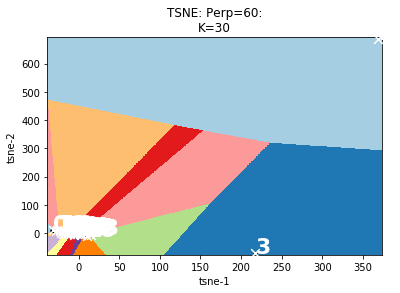

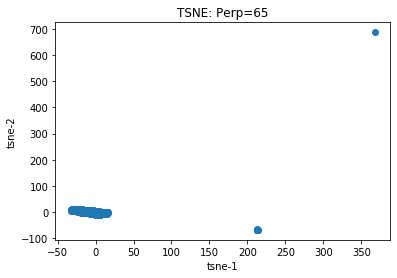

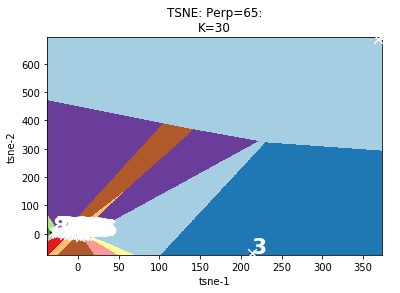

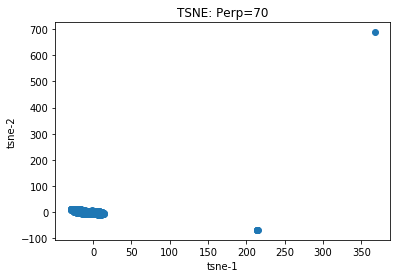

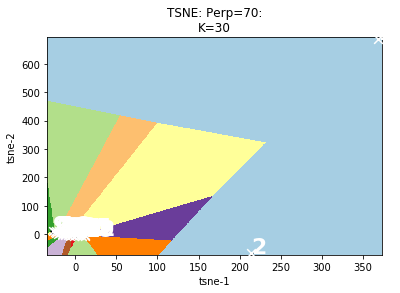

Learning Rate=200


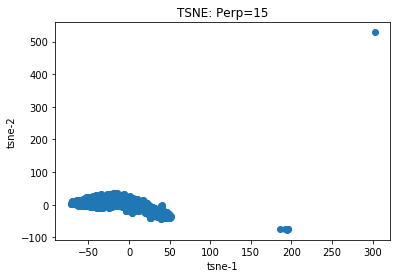

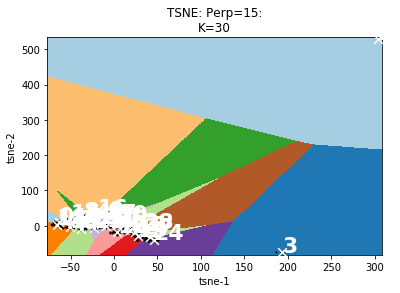

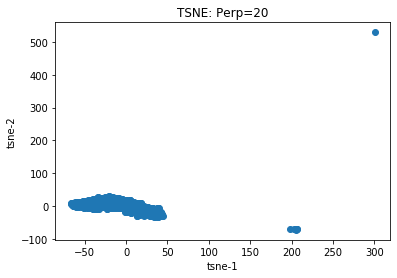

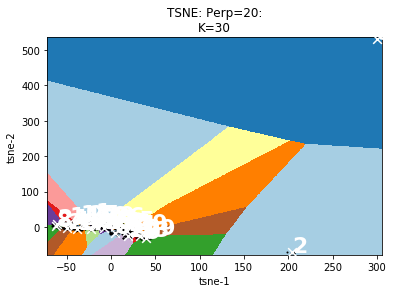

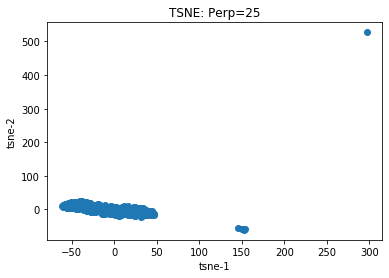

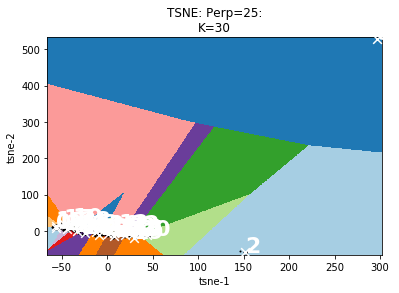

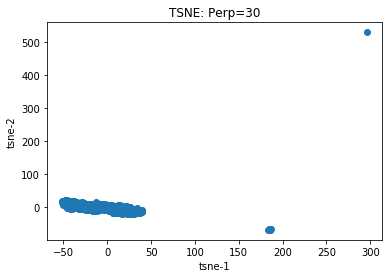

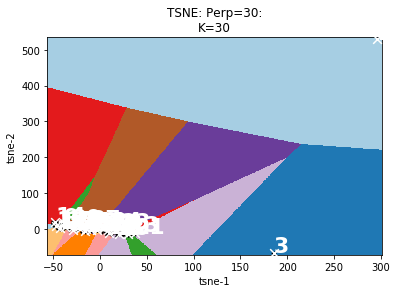

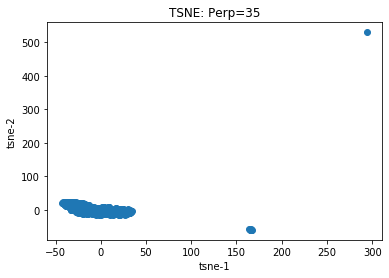

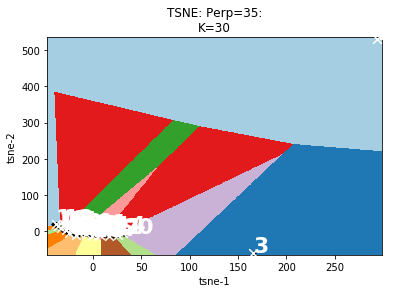

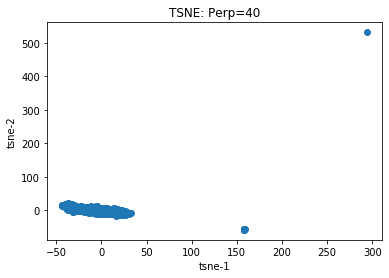

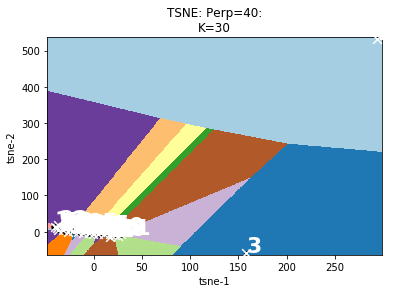

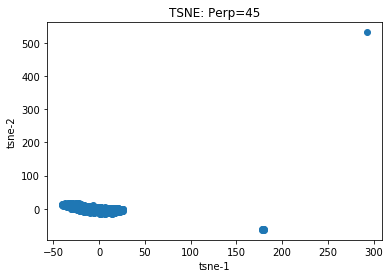

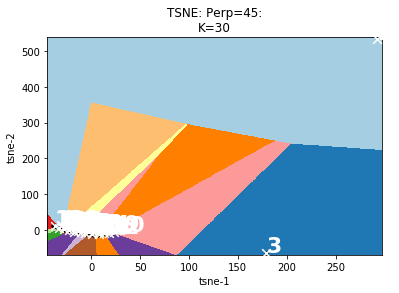

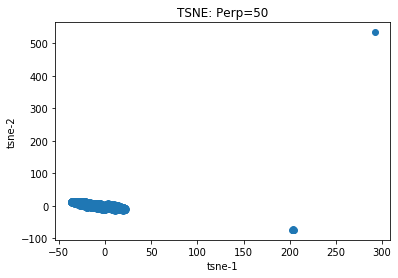

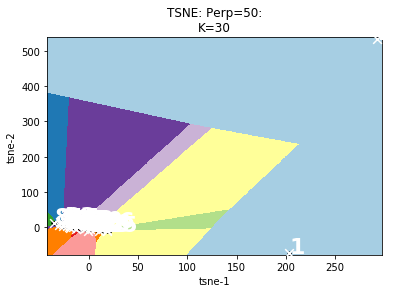

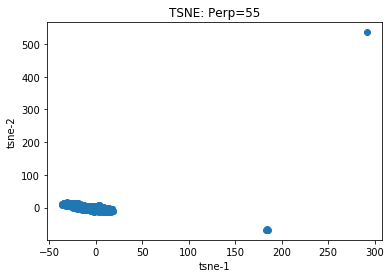

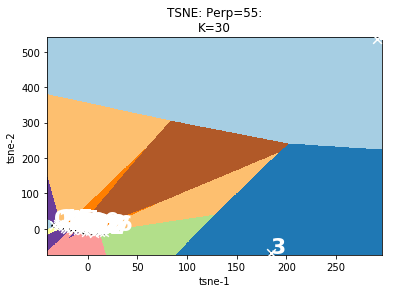

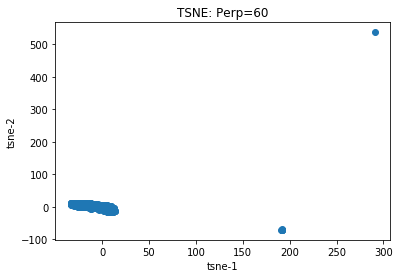

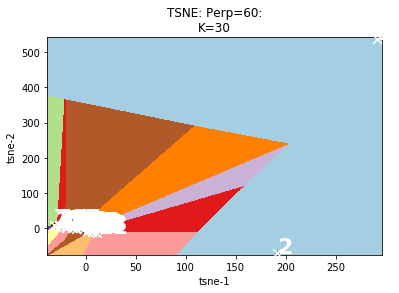

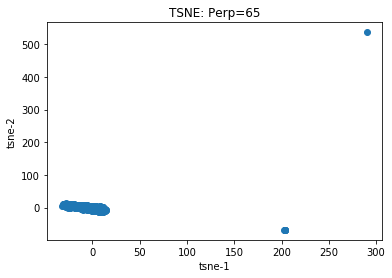

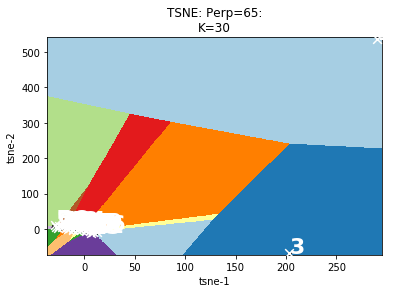

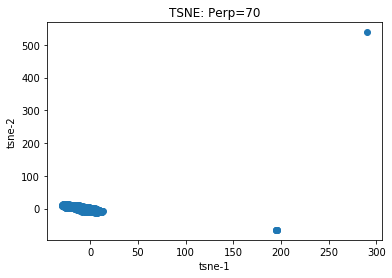

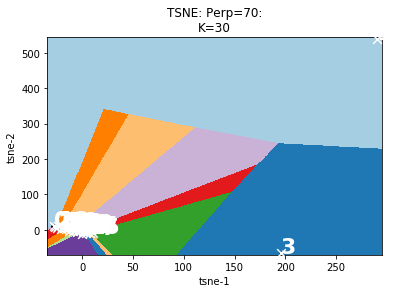

Learning Rate=300


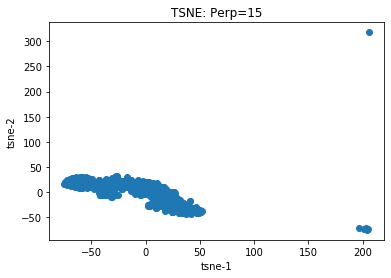

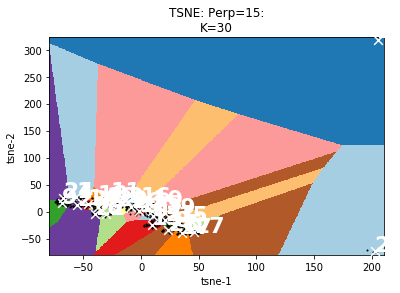

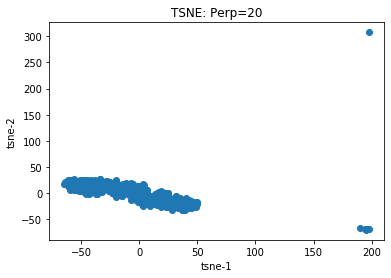

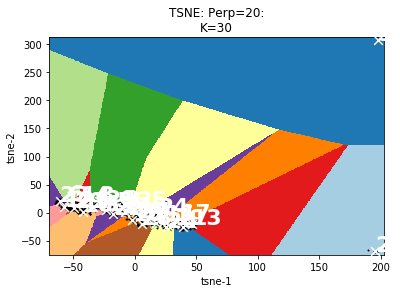

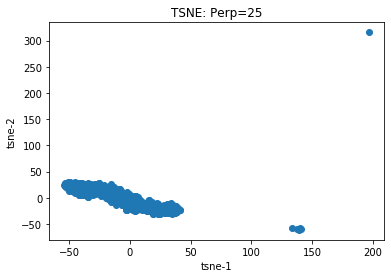

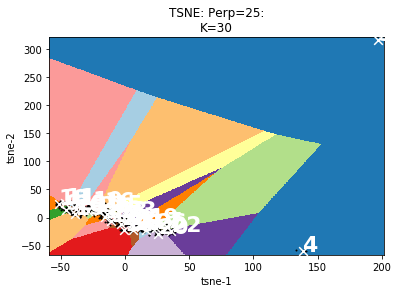

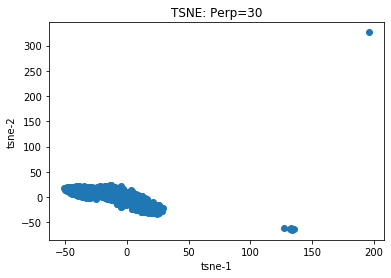

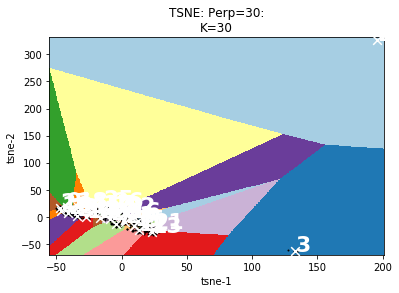

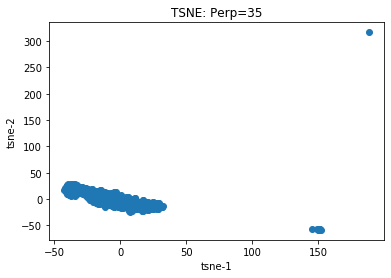

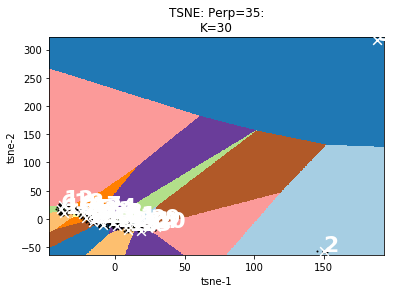

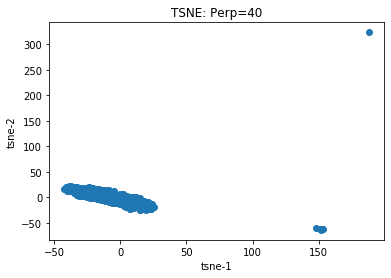

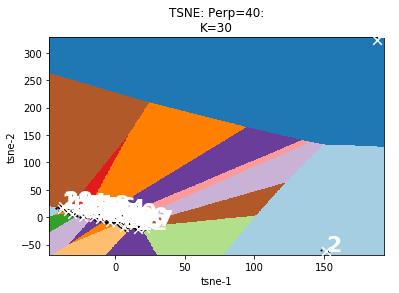

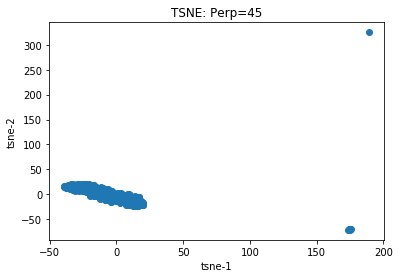

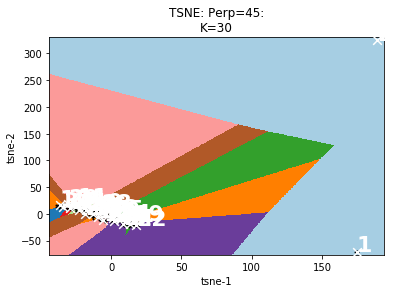

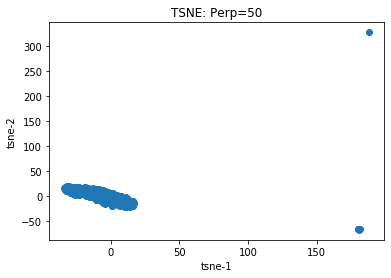

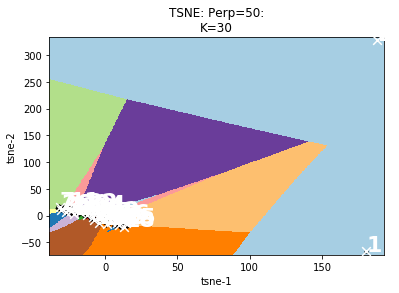

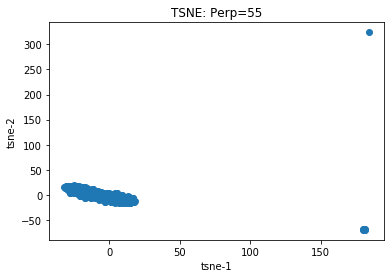

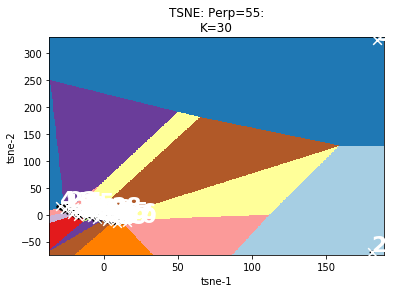

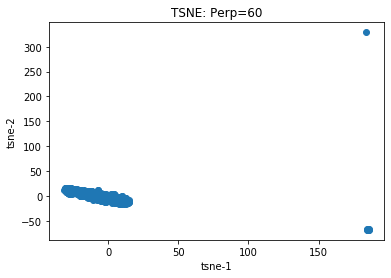

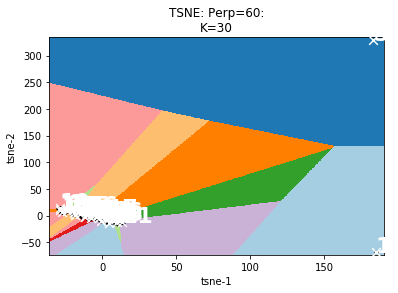

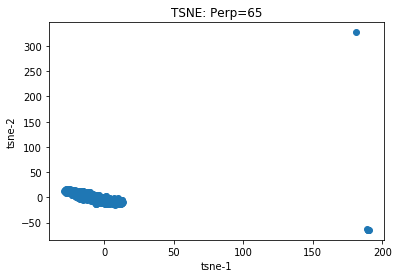

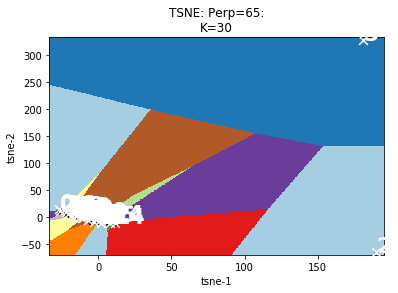

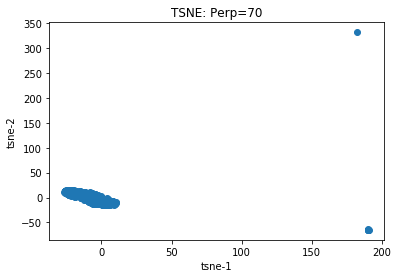

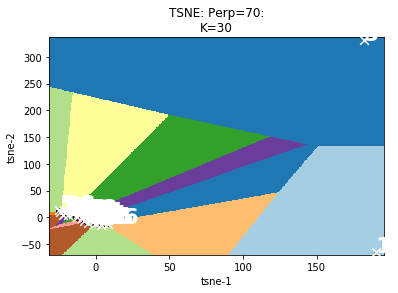

Learning Rate=400


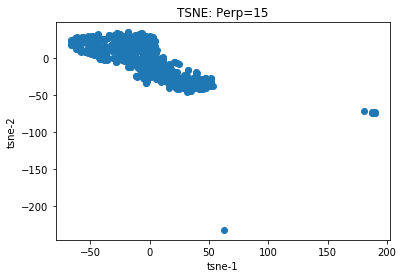

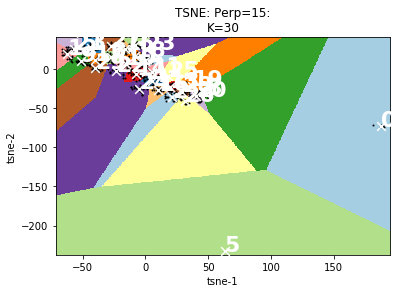

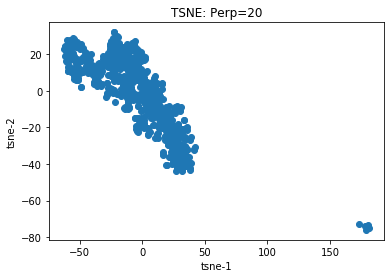

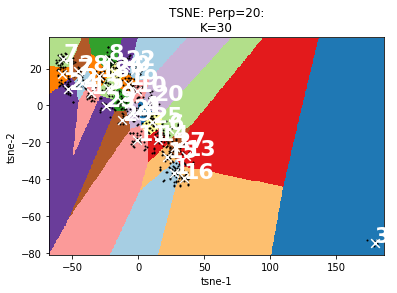

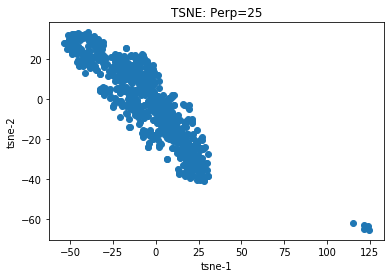

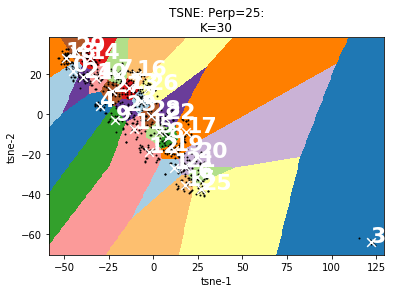

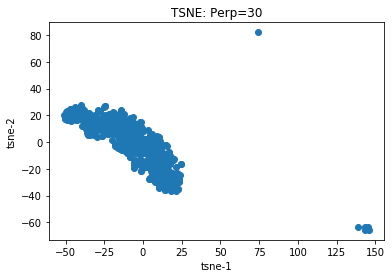

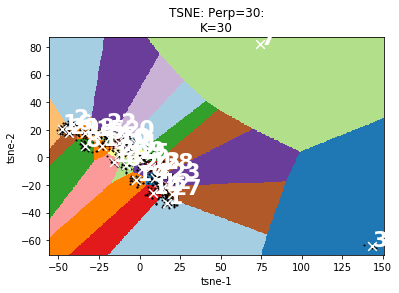

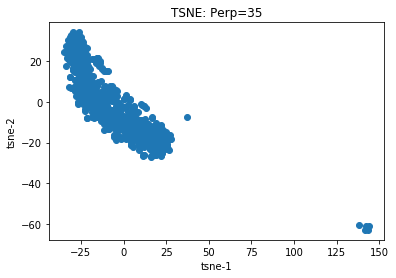

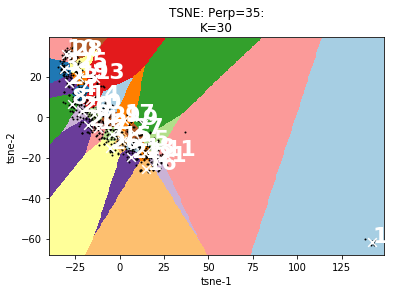

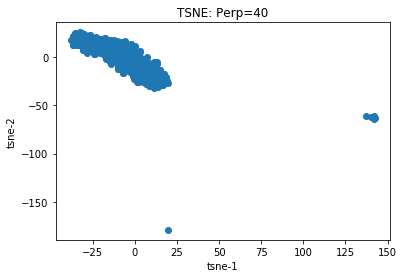

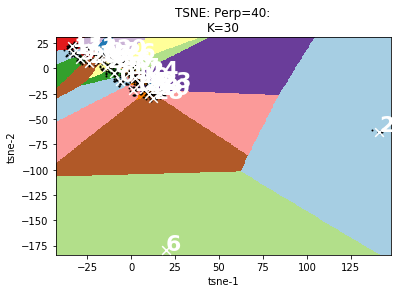

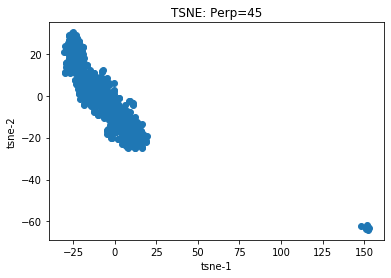

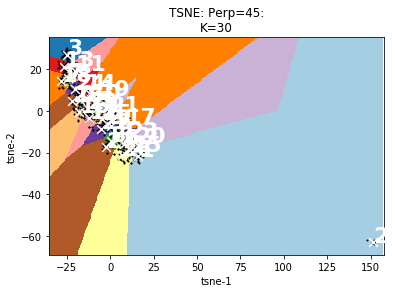

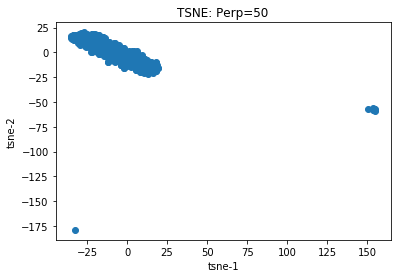

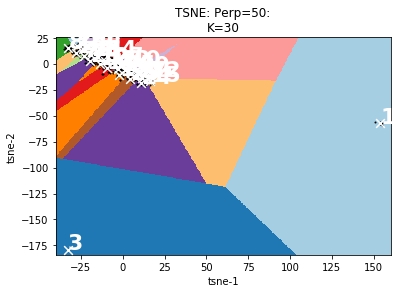

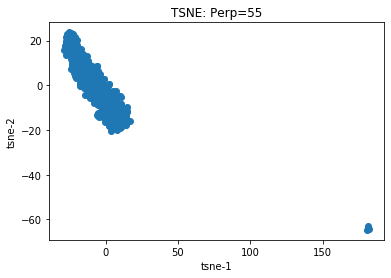

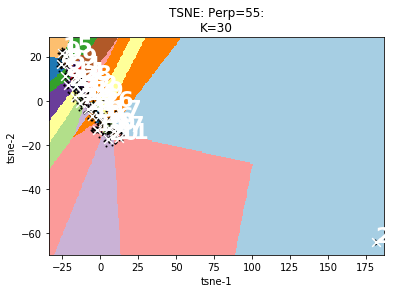

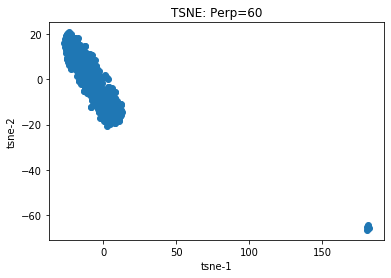

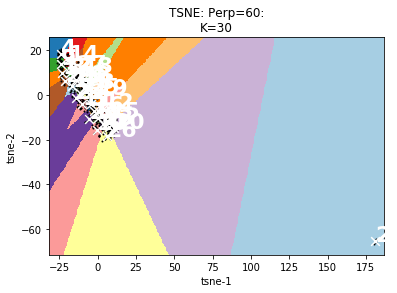

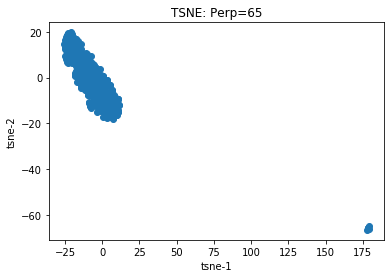

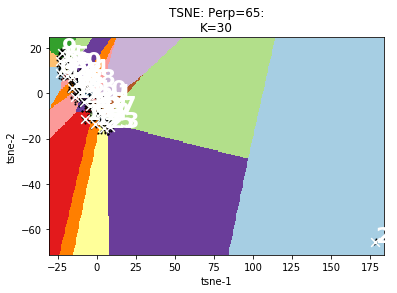

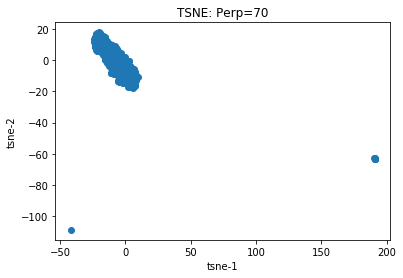

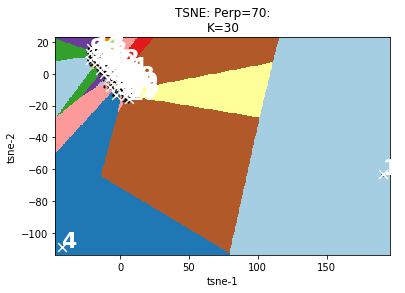

Learning Rate=500


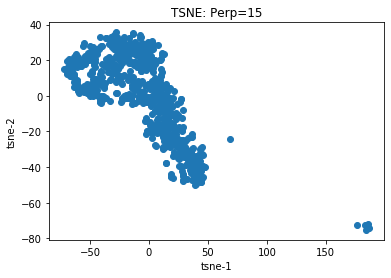

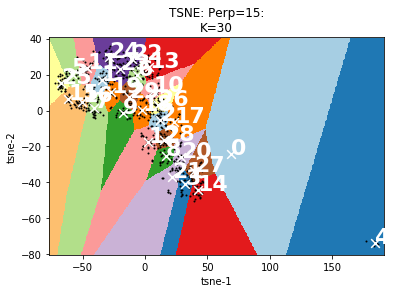

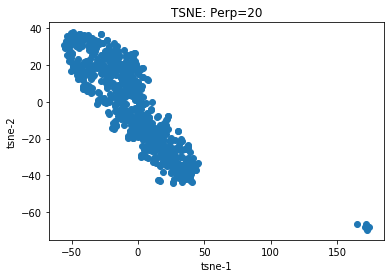

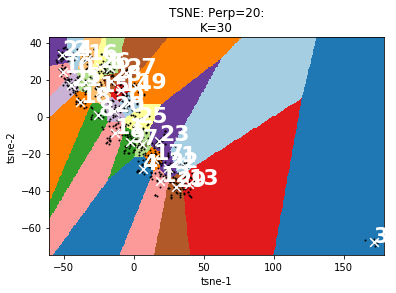

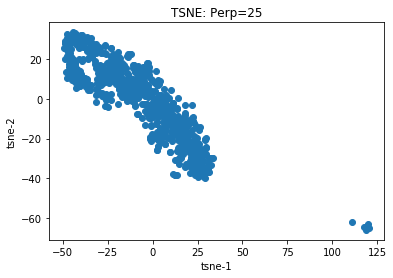

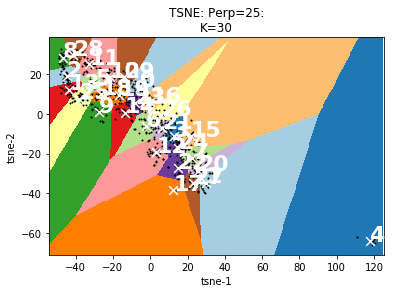

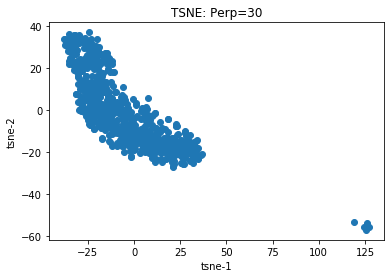

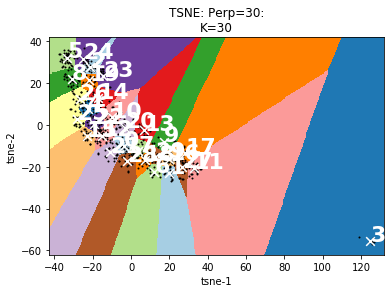

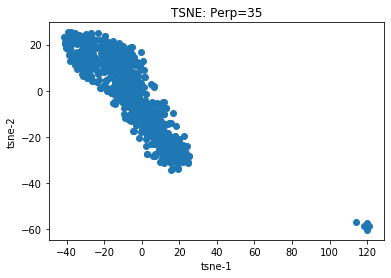

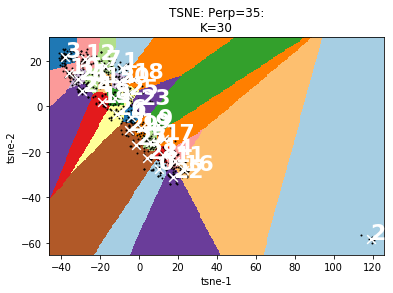

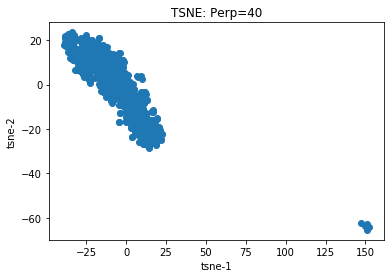

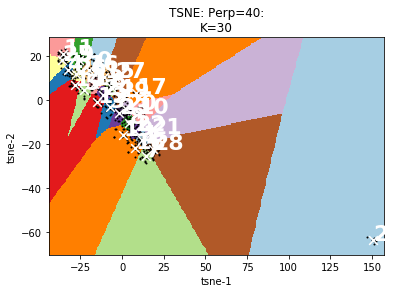

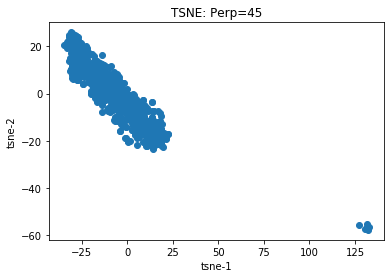

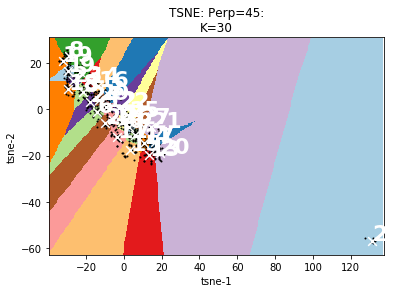

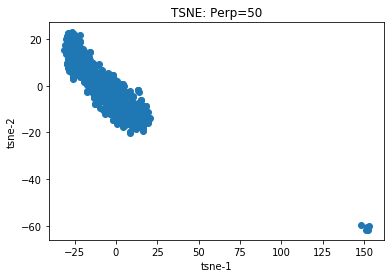

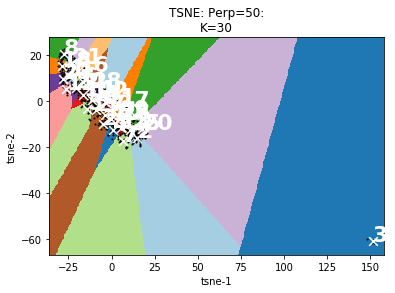

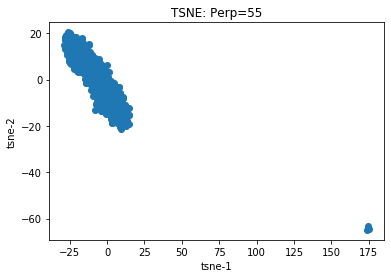

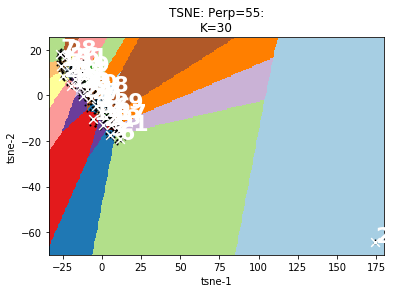

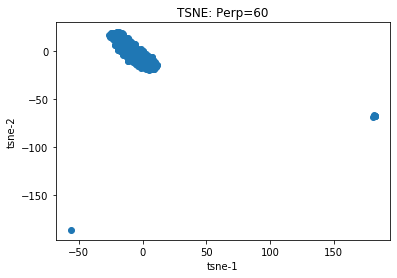

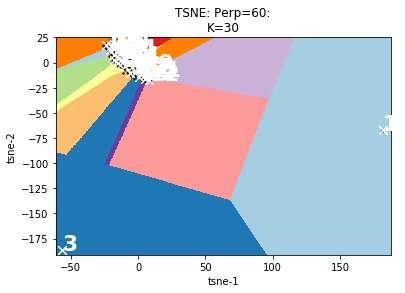

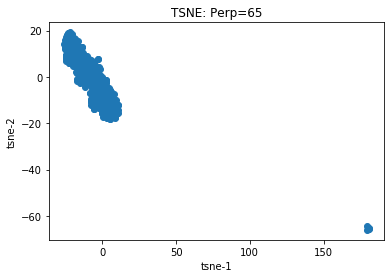

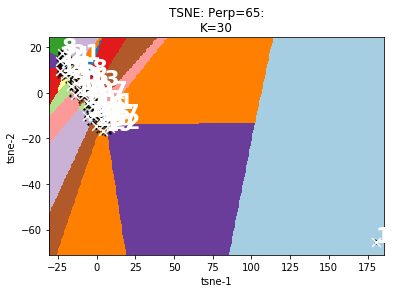

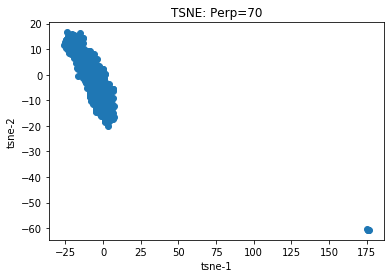

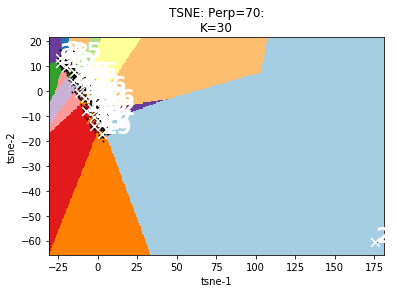

Learning Rate=600


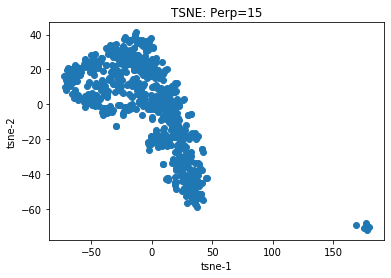

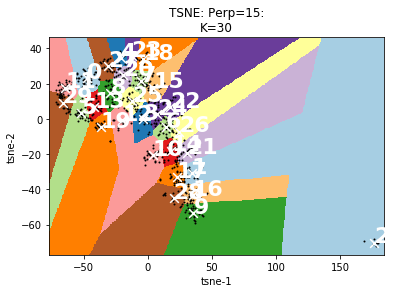

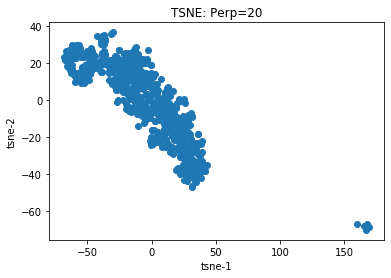

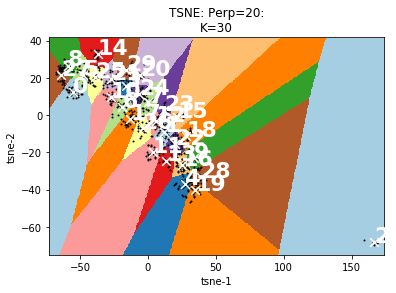

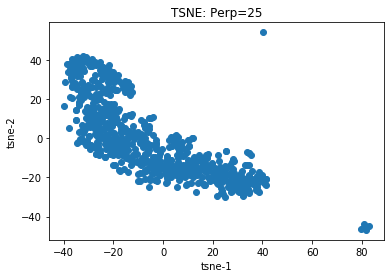

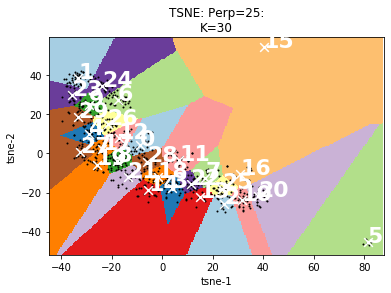

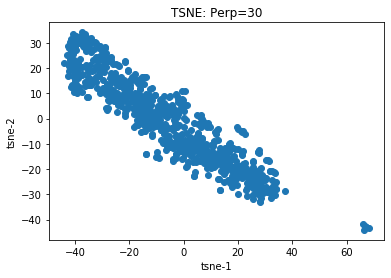

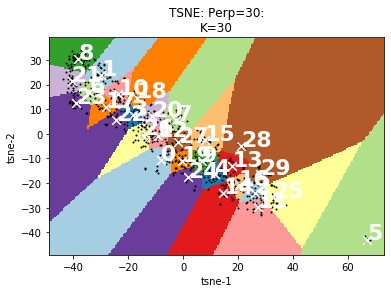

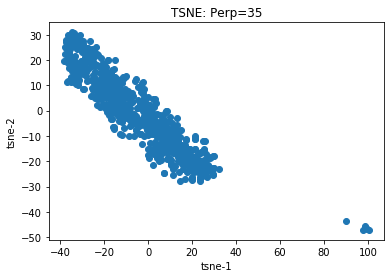

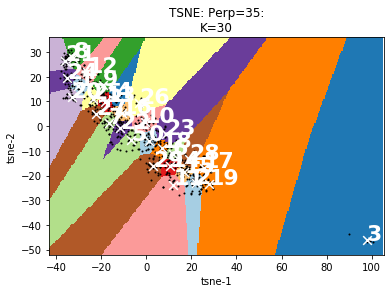

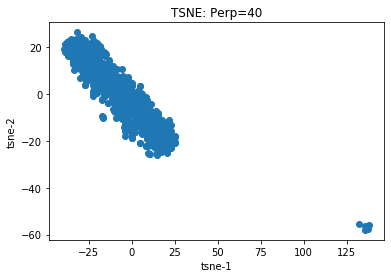

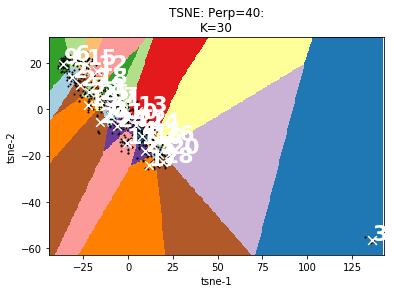

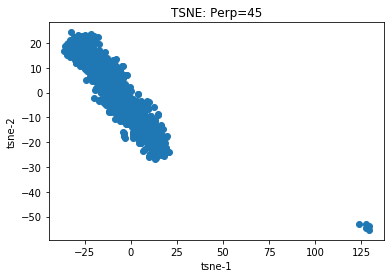

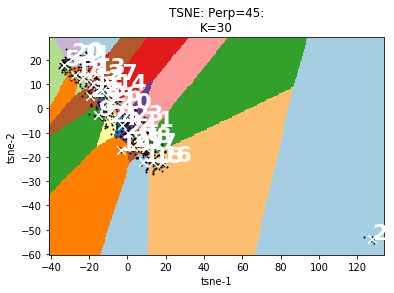

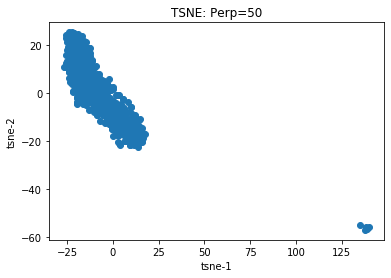

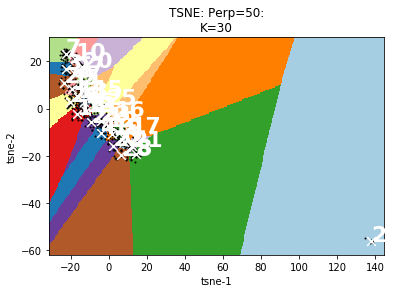

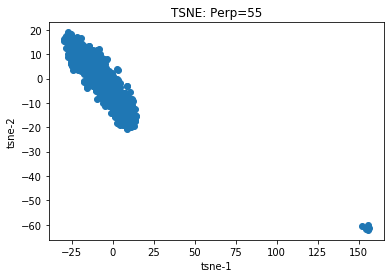

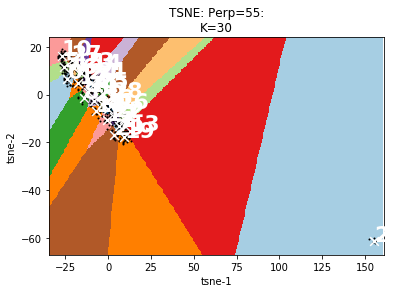

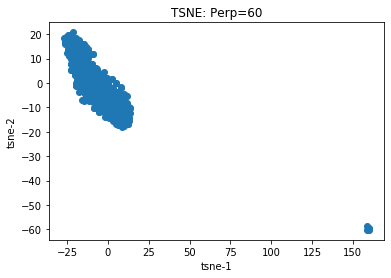

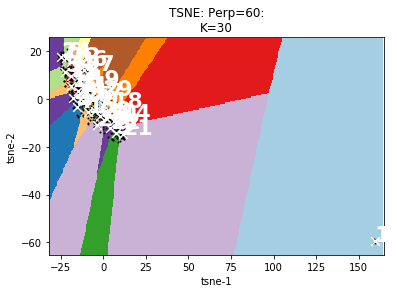

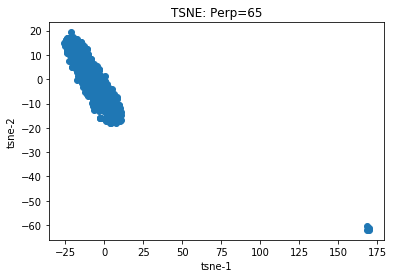

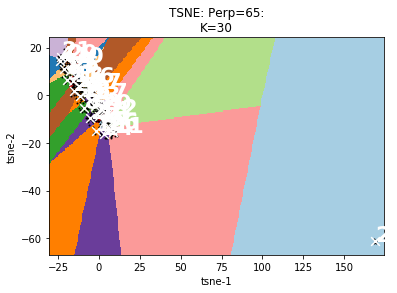

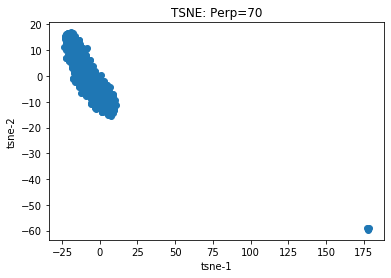

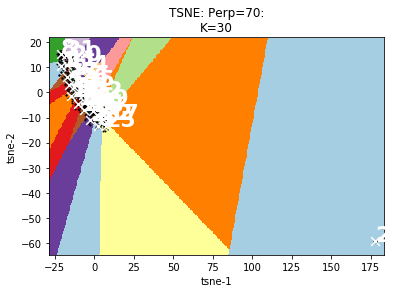

Learning Rate=700


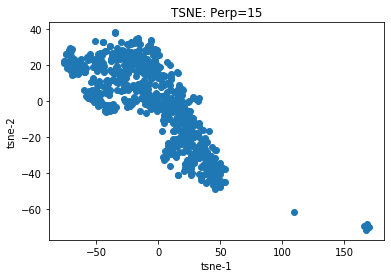

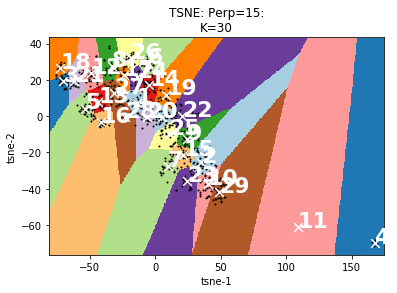

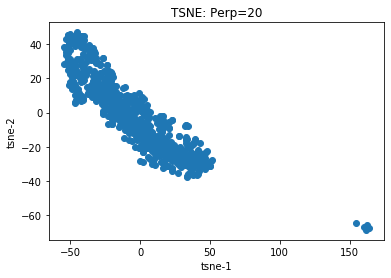

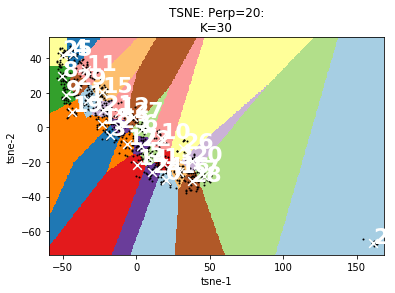

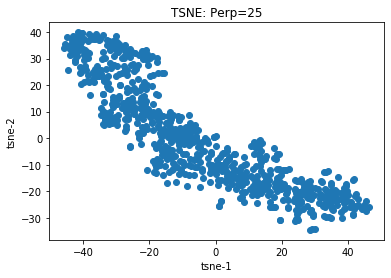

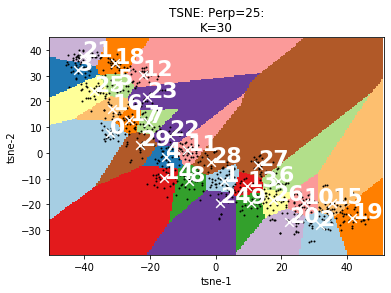

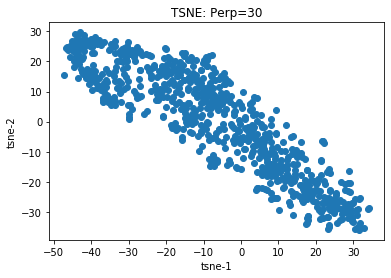

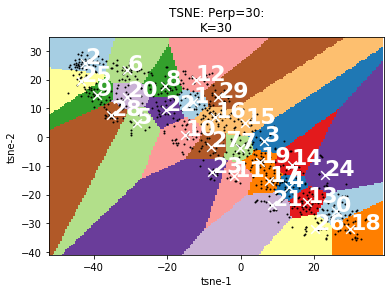

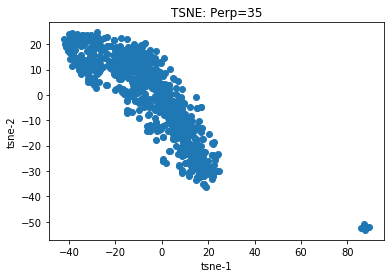

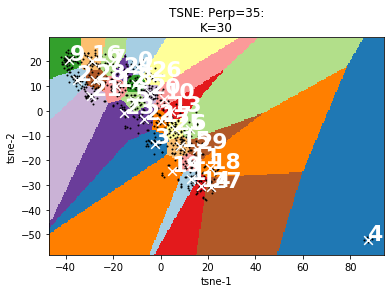

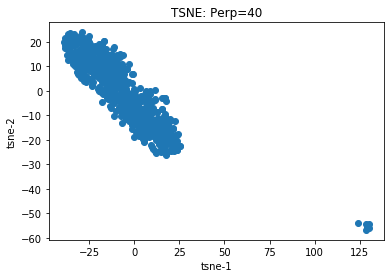

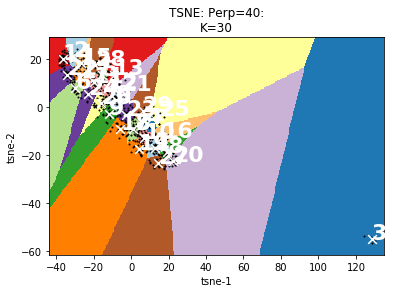

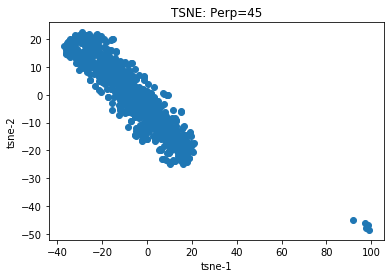

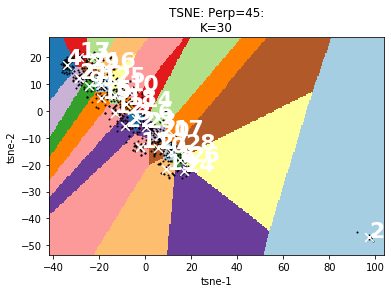

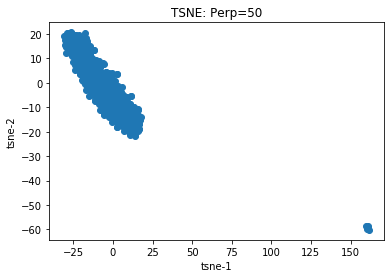

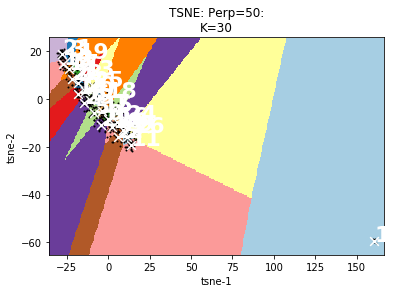

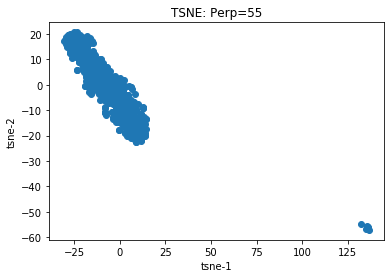

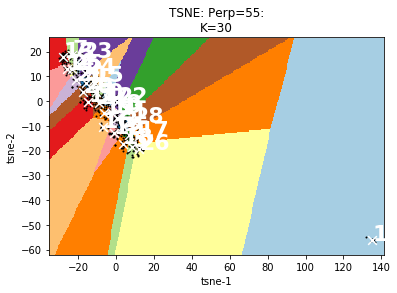

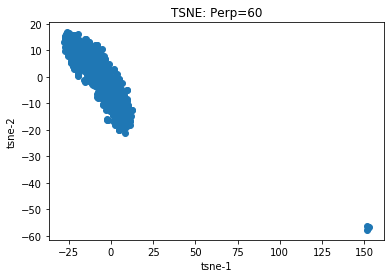

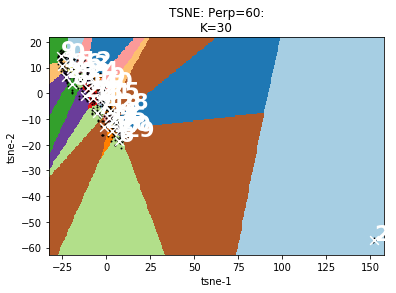

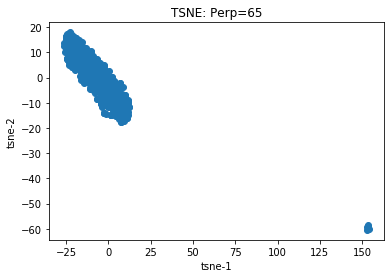

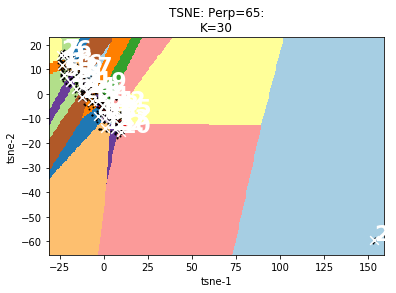

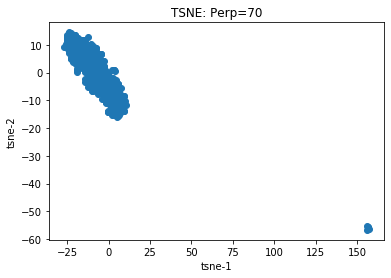

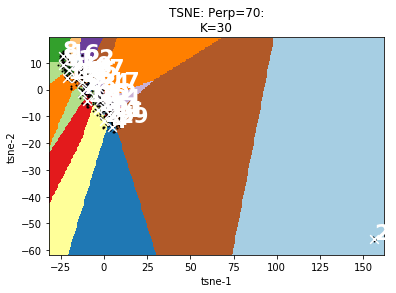

Learning Rate=800


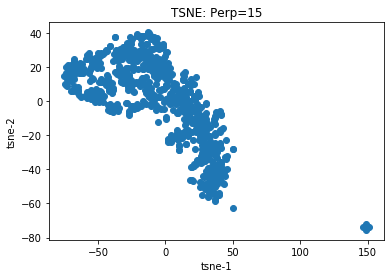

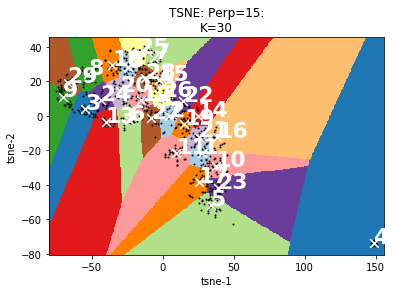

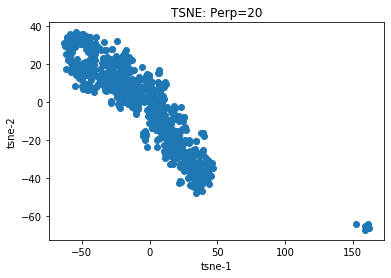

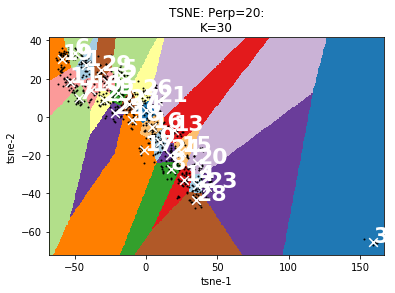

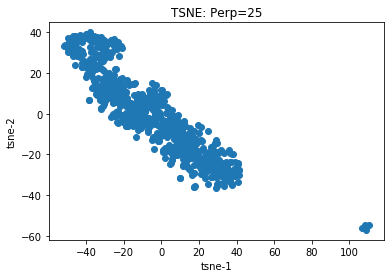

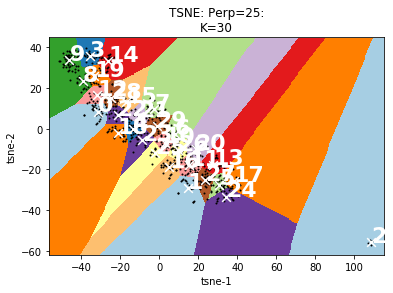

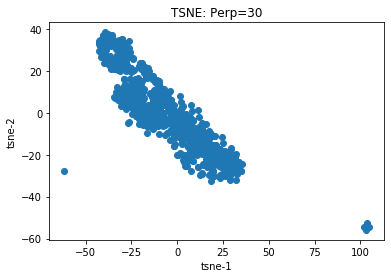

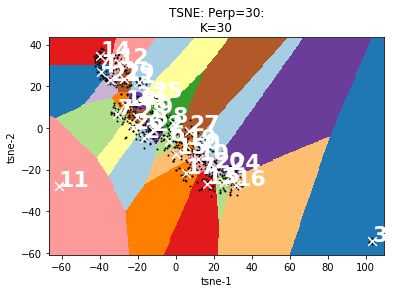

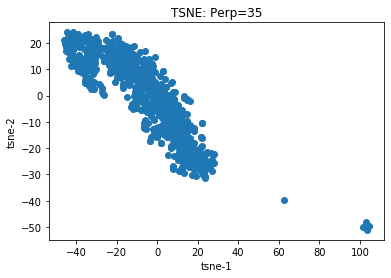

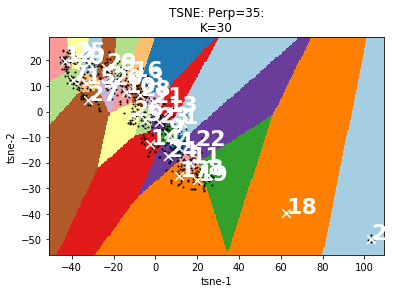

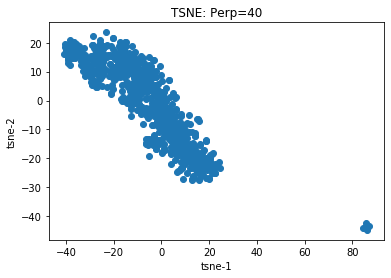

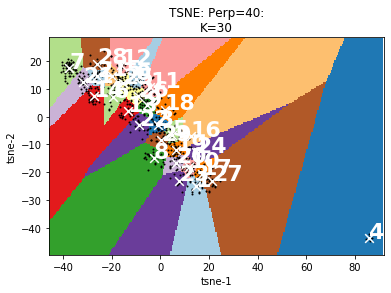

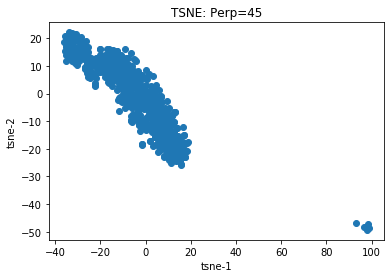

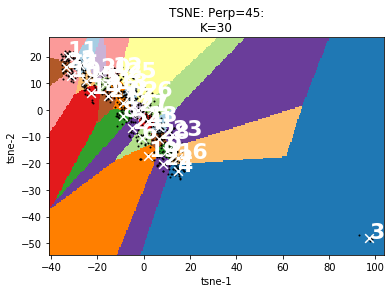

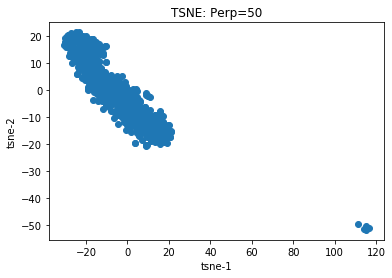

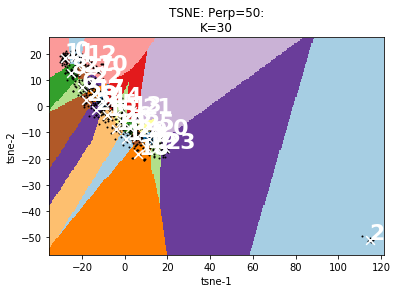

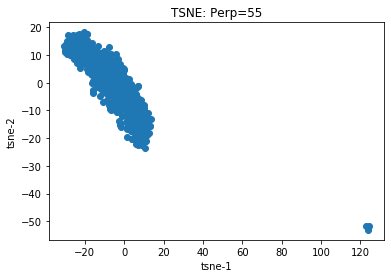

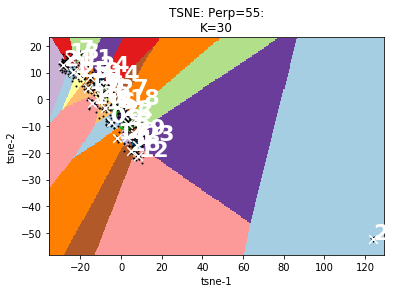

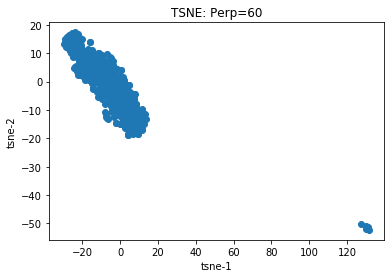

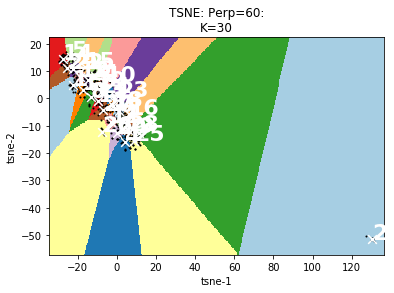

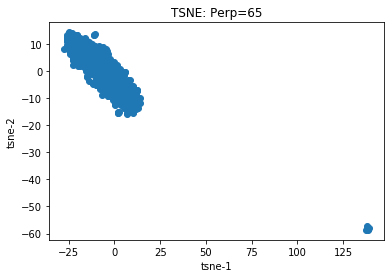

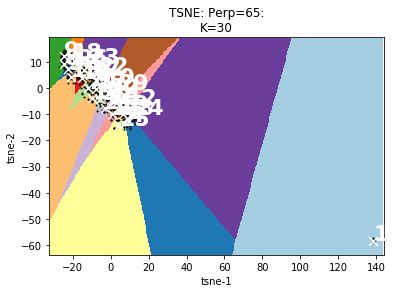

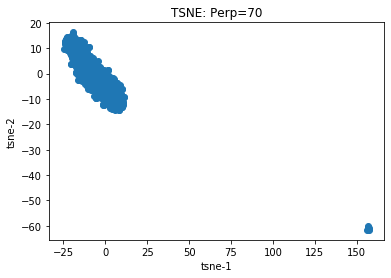

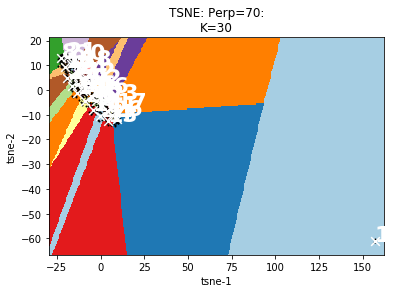

Learning Rate=900


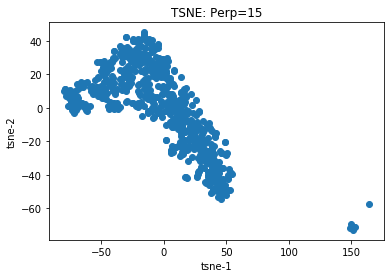

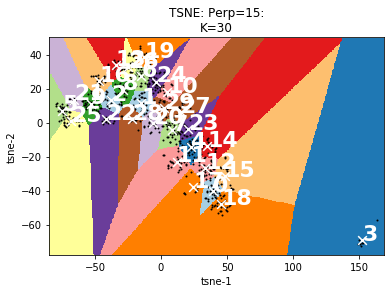

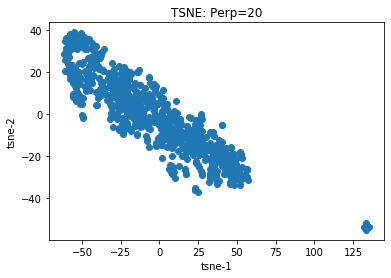

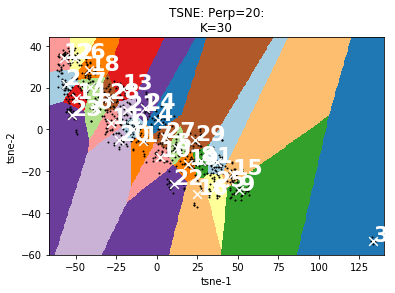

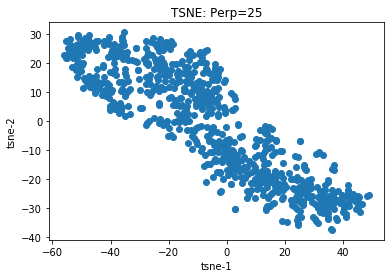

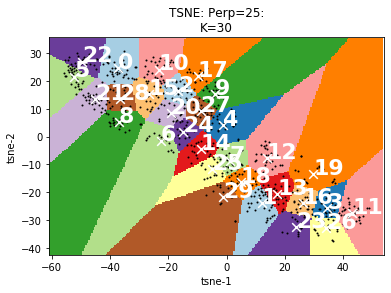

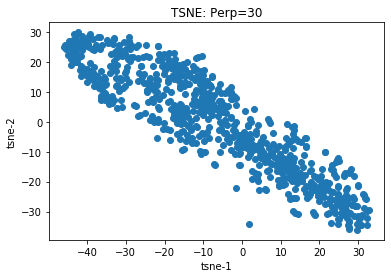

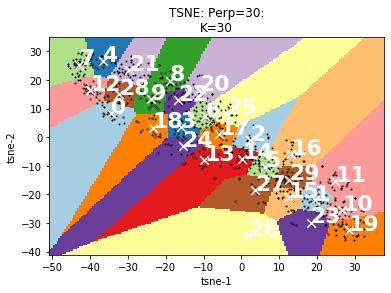

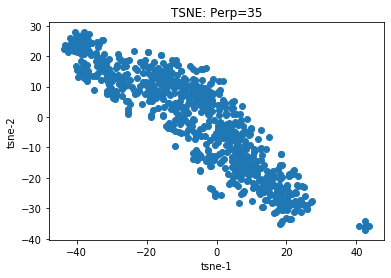

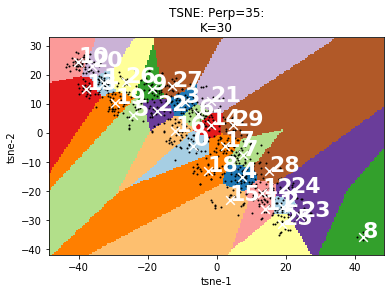

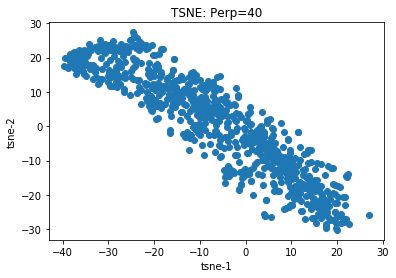

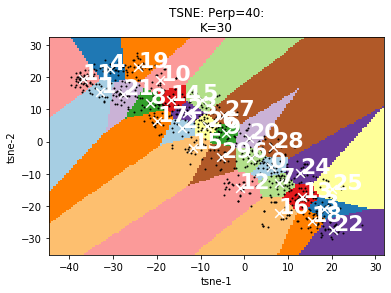

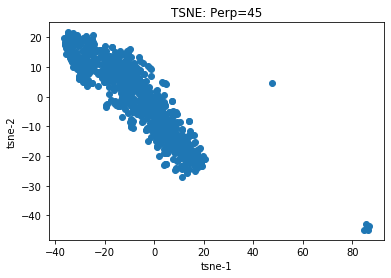

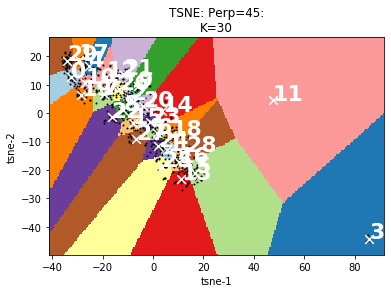

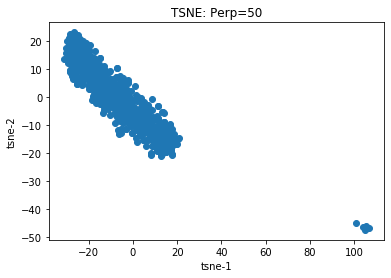

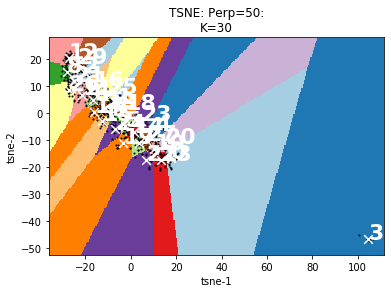

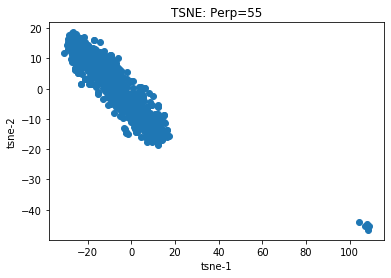

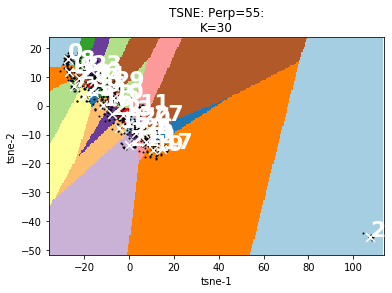

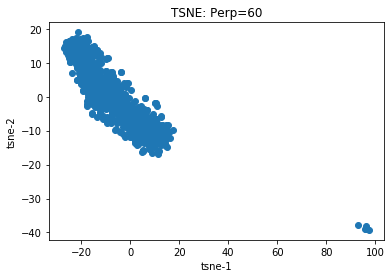

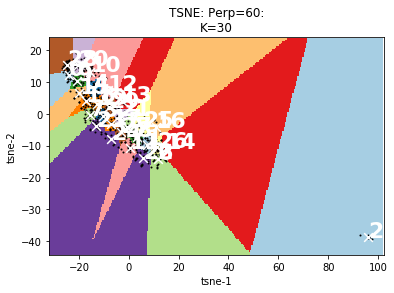

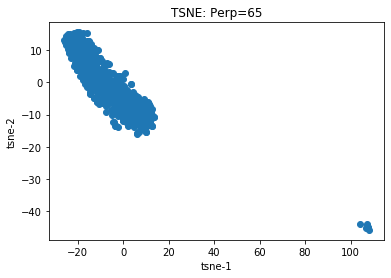

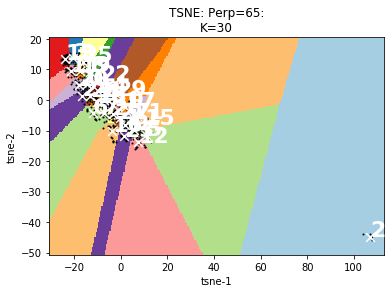

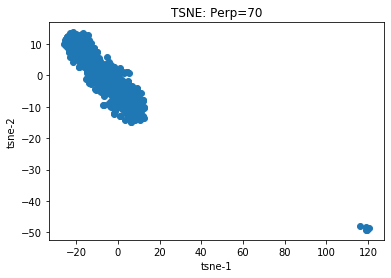

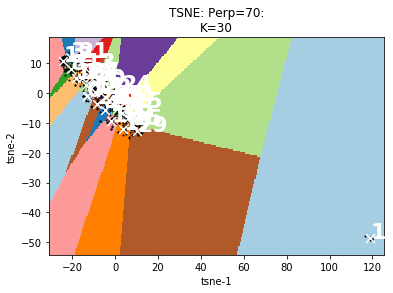

Learning Rate=1000


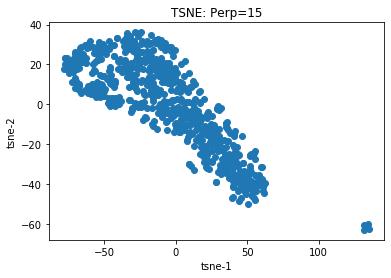

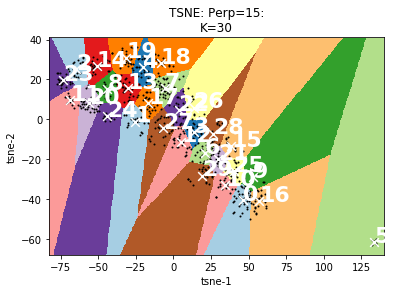

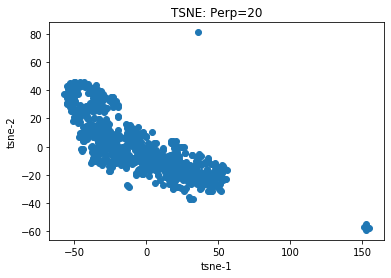

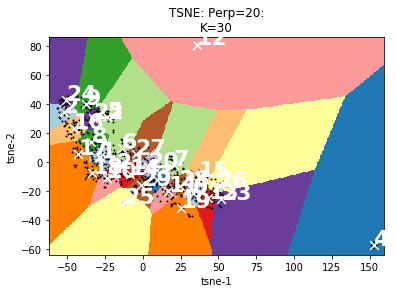

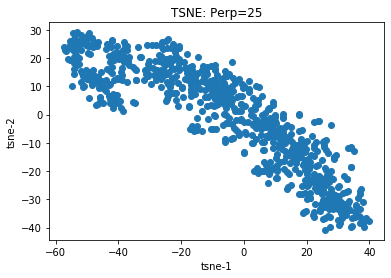

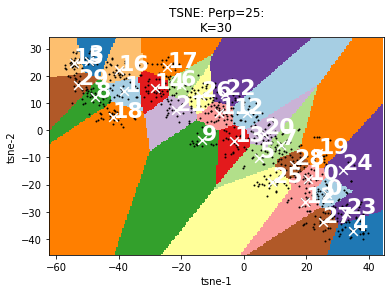

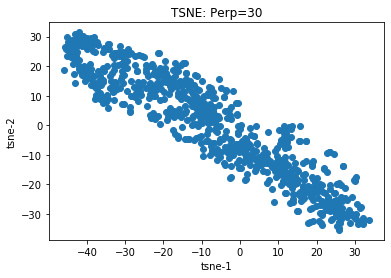

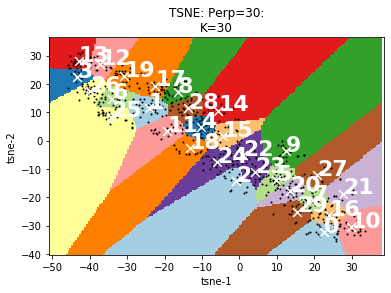

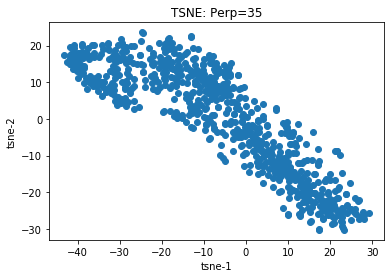

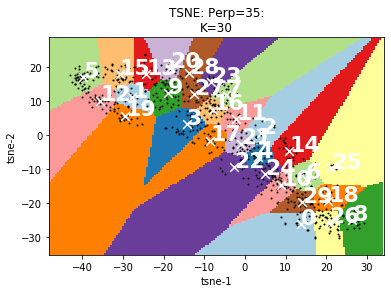

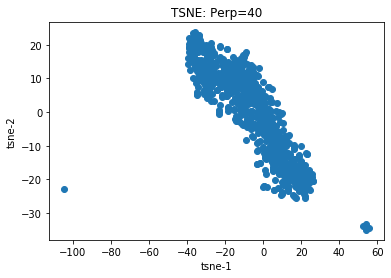

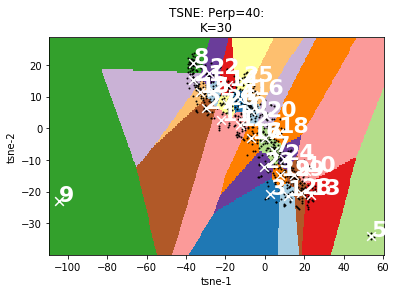

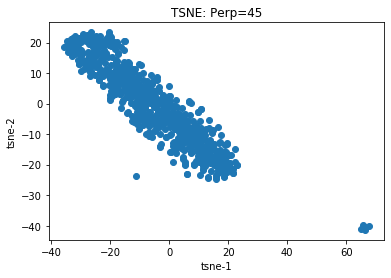

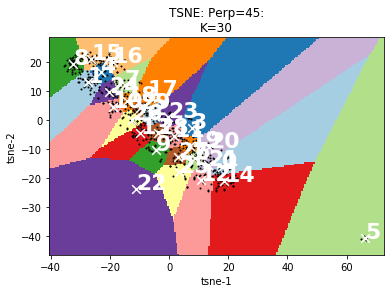

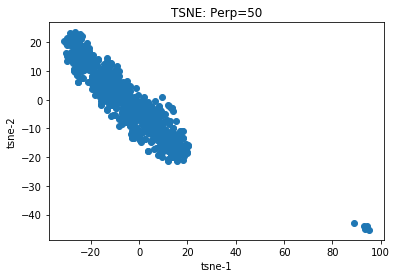

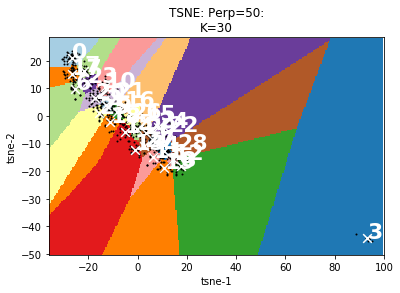

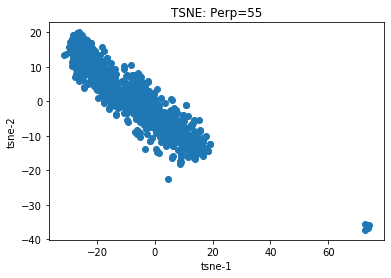

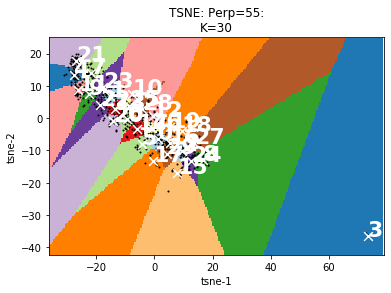

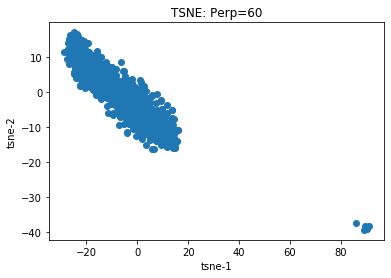

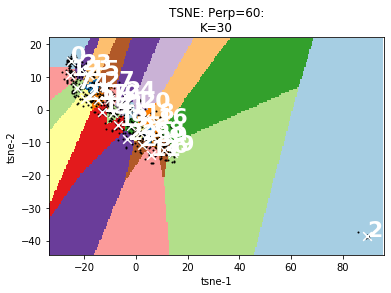

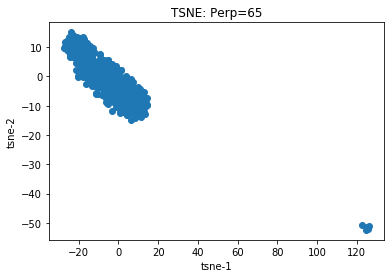

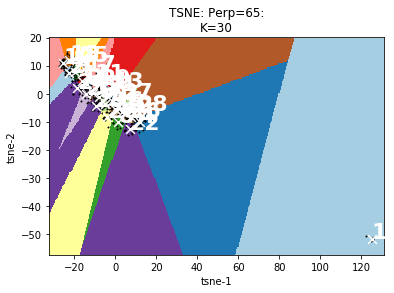

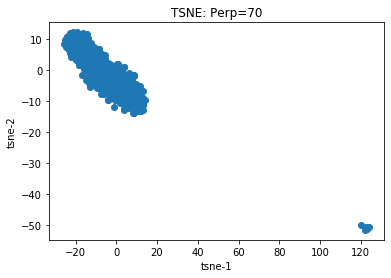

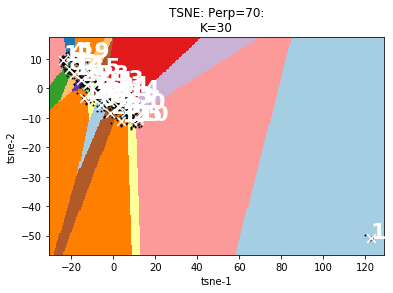

In [69]:
# pseudo grid search with rate from 100 to 1000 and perplexity between 15 and 70
# looking for graphs with separation between the clusters
for j in range(100, 1100, 100):
    rate=j
    print('Learning Rate={}'.format(j))
    for i in range(15,75,5):
        df_copy = price_final
        perp = i
        tsne = manifold.TSNE(n_components=2, init='pca', random_state=0, perplexity=perp, learning_rate=rate)
        t0 = time()
        X_all_tsne = tsne.fit_transform(de_pca)
        new_embedding(X_all_tsne, title='TSNE: Perp={}'.format(i), xlabel='tsne-1', ylabel='tsne-2')
        kmeans = colorize_kmeans(data=X_all_tsne, num_clusters=k_value, step_size=step, num_iter=10, title='TSNE: Perp={}:\nK={}'.format(i, k_value),
                                xlabel='tsne-1', ylabel='tsne-2')
        df_copy['cluster_labels'] = kmeans.labels_
        df_copy['centroid_distance'] = kmeans.inertia_

## TODO 
### -build dictionary of candidate portfolio DFs for each graph
### -pick stock from each group (based on closeness to cluster center)
### -plot/build efficient frontier to determine weighting

In [ ]:
print('For debt to equity ratio, perplexity between 15 and 40, and learning rate between 400 and 1000')
portfolio_dict = {}
for j in range(100, 1100, 100):
    rate=j
    print('Learning Rate={}'.format(j))
    for i in range(15,75,5):
        df_copy = pd.DataFrame(data = de_pca, index = de_final.index)
        perp = i
        tsne = manifold.TSNE(n_components=2, init='pca', random_state=0, perplexity=perp, learning_rate=rate)
        t0 = time()
        X_all_tsne = tsne.fit_transform(de_pca)
        new_embedding(X_all_tsne, title='TSNE: Perp={}'.format(i), xlabel='tsne-1', ylabel='tsne-2')
        kmeans = colorize_kmeans(data=X_all_tsne, num_clusters=k_value, step_size=step, num_iter=10, title='TSNE: Perp={}:\nK={}'.format(i, k_value),
                                xlabel='tsne-1', ylabel='tsne-2')
        df_copy['cluster_labels'] = kmeans.labels_
        df_copy['centroid_distance'] = kmeans.inertia_

In [ ]:
# reference code

k_value = 25
dic_of_top_stocks = {}
for i in range(15,75,5):
    df_copy = df09_18.iloc[:, 2:].copy()
    perp = i
    tsne = manifold.TSNE(n_components=2, init='pca', random_state=0, perplexity=perp, learning_rate=50)
    t0 = time()
    X_all_tsne = tsne.fit_transform(X09_18)
    plot_embedding(X=X_all_tsne, y=y_all, title='All Years tSNE Mapping: Perplexity = {}'.format(perp))
    
    """BEGIN KMEANS"""
    print('begin kmenans')
    kmeans = colorize_kmeans(data=X_all_tsne, num_clusters=k_value, num_iter=10, title='TSNE: Perp={}:\nK={}'.format(i, k_value))
    #labels = pd.Series(kmeans.labels_)
    df_copy['cluster_labels'] = kmeans.labels_
    """LISTS OF THE MEANS RETURNS OF EVERY CLUSTER VALUE"""
    cluster_means_k = []
    cluster_vars_k = []

    for cluster_index in range(k_value):
        """FILTER BY CLUSTER VALUE"""
        temp_df = df_copy[df_copy['cluster_labels']==cluster_index].T.iloc[2:-1, :]
        stock_symbols = temp_df.columns
        """TEMP CLUSTER MEANS AND VARIANCES ACCROSS STOCKS"""
        cluster_means = []
        cluster_vars = []
        for symbol in stock_symbols:
            """FOR EVERY STOCK, TAKE THE AVERAGE RETURN AND AVERAGE VARIANCE"""
            
            temp_series = temp_df[[symbol]]
            temp_mean   = temp_series.mean()
            temp_var = temp_series.var()
            cluster_means.append(temp_mean[0])
            cluster_vars.append(temp_var[0])
            """ONCE THE AVERAGE RETURN AND AVERERAGE VARIANCE IS COMPUTED ACCROSS ALL STOCKS, APPEND TO THE EMPTY LISTS ABOVE"""    
        cluster_means_k.append(np.mean(cluster_means))
        cluster_vars_k.append(np.mean(cluster_vars))
        #print('cluster means appended')
    
    clusterk_means_num = []
    for cluster, mean in enumerate(cluster_means_k):
        """FOR EVERY ENUMERAATED CLUSTER APPEND THE CLUSTER VALUE AND MEAN RETURN AND SORT BY THAT"""
        #print(cluster, mean)
        clusterk_means_num.append((cluster, mean))
    ### sort the list
    clusterk_means_num.sort(key=lambda x: x[1], reverse=True) 
        
    ### pick index     
    index_best_cluster = clusterk_means_num[0][0]
    print('The best cluster was cluster {}'.format(index_best_cluster))
    
    best_df = df_copy[df_copy['cluster_labels']==index_best_cluster].T.iloc[2:-1, :]
    print('best df has shape {}'.format(best_df.shape))
    """merge the df whose cluster index has the highest avg return"""
    reduced_df_final = pd.merge(best_df.T.iloc[:, 0], df19, how='inner', on=None, left_on=None, right_on=None,
             left_index=True, right_index=True, sort=True,
             suffixes=('_x', '_y'), copy=True, indicator=False).T.iloc[3:, :]

    reduced_df_final.index = pd.to_datetime(reduced_df_final.index, format='%d/%b/%Y', infer_datetime_format=True)
    print('reduce df final has shape {}'.format(reduced_df_final.shape))
    ########
    ###########--------Merge with the price DF-------------#########
    #######
    prices = pd.merge(reduced_df_final.iloc[0, :].T, df_close19.T, how='inner', on=None, left_on=None, right_on=None,
             left_index=True, right_index=True, sort=True,
             suffixes=('_x', '_y'), copy=False, indicator=False).T.iloc[1:, ]
    print(prices.shape)
    returns = prices.apply(lambda x: total_return(x), axis=0)
    print('Cluster {} had a total return of {} in the first 3 quarters of 2019'.format(index_best_cluster, np.mean(returns)))
    
    
    """append dictionary... with the stock symbols that belonged to the cluster"""
    stocks_per_top_cluster = tuple(prices.columns)
    dic_of_top_stocks['k{}_perp{}'.format(k_value, perp)] = stocks_per_top_cluster
    #list_of_top_stocks.append(stocks_per_top_cluster)
    """what is the set of all clusters belonging to the top clusters?"""
    
    


    """plot the company returns of best average cluster"""
    sp_return = 0.20177154127199878
    plt.hist(returns, bins=10)
    plt.axvline(x=0., color='red')
    plt.axvline(x=sp_return, color='yellow')
    plt.axvline(x=np.mean(returns), color='black')
    plt.xlim(-0.8, 0.8)
    plt.title('Total Returns: Best Portfolio where K={}\n1/1/19-9/30/19'.format(k_value))
    #plt.savefig('Best_Portfolio3_2pca.png')
    plt.show()
